# Reinforcement Learning for Navigation Network Study

In [1]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import MultiAgentVecEnv

from mlagents_envs.exception import UnityTimeOutException, UnityWorkerInUseException
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

import torch as th

import os, yaml
import random
import time
import datetime
import numpy as np
import torch as th
from torch import nn

from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToMultiGymWrapper 
import wandb
from rlnav.logging import WANDBMonitor, test_model
from rlnav.schedules import linear_schedule
from pathlib import Path

from typing import Callable, Dict, List, Optional, Tuple, Type, Union

import gym
import torch as th
from torch import nn

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy

In [2]:
import numpy as np
import networkx as nx
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

Using backend: pytorch


In [3]:
from torchsummary import summary

In [4]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

## The Incoming Data

![The Point the data is gathered](tmp/Observation.png "The observation")

In [6]:
observations = np.load('UrbanObservation505.npy')
print("Loaded shape:", observations.shape)
observations = observations.squeeze()

vector_size    = 19 
whisker_size   = 26 + 6 # 6 represents the rotation observation which is included in depth_map component but can be ignored.
depth_size     = 55 - 6
occupancy_size = 405

vector_end    = vector_size
whisker_end   = vector_end  + whisker_size
depth_end     = whisker_end + depth_size
occupancy_end = depth_end   + occupancy_size

Loaded shape: (25000, 1, 505)


In [7]:
observations = np.array(observations)

In [8]:
class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the feature extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super(CustomNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.policy_net(features), self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = True

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

In [9]:
model = PPO(CustomActorCriticPolicy, "CartPole-v1", verbose=1)

observations_th = th.tensor(observations).cuda() 
model.policy(observations_th)

Using cuda device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
1


(tensor([0, 1, 1,  ..., 1, 1, 1], device='cuda:0'),
 tensor([[-0.0779],
         [-0.1924],
         [-0.0064],
         ...,
         [-0.0503],
         [-0.0549],
         [ 0.0081]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([-0.6927, -0.6943, -0.6932,  ..., -0.6935, -0.6937, -0.6936],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

In [10]:
jsonstr = """{"SourceNodes":[0,0,2,2,2,2,2,2,8,9,9,9,9,9,9,9,9,8,18,18,18,18,18,18,18,18,18,18,2,29,29,29,29,2,34,35,35,35,35,35,35,35,35,34,44,44,44,44,44,44,44,44,44,44,34,55,55,55,55,55,55,55,55,55,55,34,66,66,66,66,66,66,66,66,66,66,66,66,2,79,79,81,81,81,81,81,81,81,81,81,81,81,92,92,92,81,96,96,96,96,96,96,81,103,103,103,81,79,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,79,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,220,2,332,333,333,333,333,333,333,333,333,332,342,342,342,342,342,342,342,342,342,342,342,342,342,2,2,2,2,2,360,360,362,2,2],"DestinationNodes":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365],"NumNodes":366,"Features":[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,0.7,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,0.7,0.7],[3.0,3.0,0.0,-35.0,0.0,0.0,0.0,0.0,1.0,91.0,4.1258,91.0,0.0,-50.0,0.0,0.0,0.0,0.0,1.0,130.0,5.894,130.0],[4.0,4.0,10.6145983,-0.7,37.8,0.0,0.0,0.0,1.0,37.45221,1.21105969,5.7057,15.1637115,-1.0,54.0,0.0,0.0,0.0,1.0,53.50316,1.73008537,8.151],[5.0,5.0,2.38959742,-0.7,0.0,0.0,0.0,0.0,1.0,21.0,1.21105969,5.7057,3.41371059,-1.0,0.0,0.0,0.0,0.0,1.0,30.0,1.73008537,8.151],[6.0,6.0,27.9045963,-8.749999,-16.304821,0.0,0.0,0.0,1.0,35.0,17.5,58.9094,39.86371,-12.499999,-23.2926,0.0,0.0,0.0,1.0,50.0,25.0,84.15629],[7.0,7.0,-26.7829037,-8.75,0.0,0.0,0.0,0.0,1.0,37.2757034,17.5,91.0,-38.26129,-12.5,0.0,0.0,0.0,0.0,1.0,53.2510033,25.0,130.0],[8.0,8.0,0.9545973,0.0,-2.1,0.0,0.0,0.0,1.0,0.7,0.7,0.7,1.3637104,0.0,-3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[9.0,3.0,0.9545973,0.0,-2.1,0.0,1.0,0.0,0.0,0.7,0.7,0.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0],[10.0,9.0,28.9545956,4.375,-44.1,0.0,1.0,0.0,0.0,0.7,8.75,2.8,-40.0,6.25,60.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[11.0,9.0,28.9545956,4.375,-30.1,0.0,1.0,0.0,0.0,0.7,8.75,2.8,-40.0,6.25,40.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[12.0,9.0,28.9545956,6.125,-37.1,0.0,0.707107842,0.707105756,0.0,0.7,11.2,3.85,-40.0,8.75,50.0,-0.707105756,0.0,0.0,0.707107842,1.0,16.0,5.5],[13.0,9.0,37.0045967,4.375,-45.1499977,0.0,-0.7071037,0.0,0.7071099,0.7000001,8.75,16.800005,-51.5,6.25,61.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[14.0,9.0,45.0545959,4.375,-37.1,0.0,-1.0,0.0,5.96046448E-06,0.7,8.75,16.8,-63.0,6.25,50.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,24.0],[15.0,9.0,37.0045967,4.375,-29.05,0.0,-0.7071037,0.0,0.7071099,0.7000001,8.75,16.800005,-51.5,6.25,38.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[16.0,9.0,41.9045944,3.5,-37.1,0.707105756,-0.7071079,4.214679E-06,4.21469031E-06,0.7000001,7.00000143,16.8000031,-58.5,5.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[17.0,9.0,32.1045952,8.4,-37.1,0.707105756,-0.7071079,4.214679E-06,4.21469031E-06,0.7000001,7.00000143,16.8000031,-44.5,12.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[18.0,10.0,73.0552444,8.75,-72.09946,0.0,5.96046448E-06,0.0,-1.0,0.7,0.7,0.7,103.000931,12.5,-99.99922,0.0,5.96046448E-06,0.0,-1.0,1.0,1.0,1.0],[19.0,9.0,28.9546547,13.125,-30.0999031,0.0,5.96046448E-06,0.0,-1.0,0.7,8.75,2.8,-63.00013,6.25,60.00011,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[20.0,9.0,28.9548244,13.125,-44.0999031,0.0,5.96046448E-06,0.0,-1.0,0.7,8.75,2.8,-63.00013,6.25,40.00011,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[21.0,9.0,28.95474,16.1,-37.0999031,0.707105756,4.214691E-06,4.214679E-06,-0.707107842,0.7,11.2,2.80016327,-63.00013,10.5,50.00011,-0.707105756,0.0,0.0,0.707107842,1.0,16.0,4.000233],[22.0,9.0,45.0547829,13.125,-37.09979,0.0,0.0,0.0,1.0,0.7,8.75,16.8,-40.0000725,6.25,50.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,24.0],[23.0,9.0,37.0049248,13.125,-45.1498833,0.0,0.7071057,0.0,0.707107961,0.7000001,8.75,16.800005,-51.5,6.25,38.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[24.0,9.0,41.9045944,12.25,-37.0999451,8.429358E-06,-1.364242E-12,-0.707105756,0.7071079,0.7000001,7.00000143,16.8,-44.5003357,5.0,49.99983,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[25.0,9.0,33.4298325,17.15,-37.0998268,8.429358E-06,-1.364242E-12,-0.707105756,0.7071079,0.7000001,8.950447,16.8,-56.60714,12.0,50.000145,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,12.7863493,24.0],[26.0,9.0,30.004734,13.125,-29.0499134,0.0,0.7071099,0.0,-0.70710367,0.7,8.75,2.8,-61.5,6.25,61.5000763,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[27.0,9.0,44.004734,13.125,-29.0497456,0.0,0.7071099,0.0,-0.70710367,0.7,8.75,2.8,-41.5,6.25,61.50008,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[28.0,9.0,37.004734,16.8874989,-29.0498314,0.499996871,0.500003159,0.500001431,-0.499998569,0.7,11.2,1.22507143,-51.5,11.625,61.5000763,-0.499999851,-0.5000002,-0.49999845,0.50000155,1.0,16.0,1.750102],[29.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,0.7,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[30.0,12.0,-52.5,14.0,0.0,0.0,-0.707106,0.0,0.7071076,119.0,84.0,14.0,-75.0,20.0,0.0,0.0,-0.707106,0.0,0.7071076,170.0,120.0,20.0],[31.0,13.0,52.5,14.0,0.0,0.0,-0.707106,0.0,0.7071076,119.0,84.0,14.0,75.0,20.0,0.0,0.0,-0.707106,0.0,0.7071076,170.0,120.0,20.0],[32.0,14.0,0.0,14.0,52.5,0.0,-3.427267E-07,0.0,1.0,119.0,84.0,14.0,0.0,20.0,75.0,0.0,-3.427267E-07,0.0,1.0,170.0,120.0,20.0],[33.0,15.0,0.0,14.0,-52.5,0.0,-3.427267E-07,0.0,1.0,119.0,84.0,14.0,0.0,20.0,-75.0,0.0,-3.427267E-07,0.0,1.0,170.0,120.0,20.0],[34.0,16.0,-38.2499962,0.0,41.2500267,0.0,0.0,0.0,1.0,0.7,0.7,0.7,-54.6428528,0.0,58.9286079,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[35.0,3.0,5.849971,0.0,-2.49984622,0.0,0.0,0.0,1.0,0.7,0.7,0.7,62.9999542,0.0,-62.4998169,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[36.0,9.0,-22.1500282,4.375,39.5001526,0.0,0.0,0.0,1.0,0.7,8.75,2.8,-40.0,6.25,60.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[37.0,9.0,-22.1500282,4.375,25.5001526,0.0,0.0,0.0,1.0,0.7,8.75,2.8,-40.0,6.25,40.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[38.0,9.0,-22.1500282,6.125,32.5001526,-0.707105756,0.0,0.0,0.707107842,0.7,11.2,3.85,-40.0,8.75,50.0,-0.707105756,0.0,0.0,0.707107842,1.0,16.0,5.5],[39.0,9.0,-30.20003,4.375,40.55015,0.0,-0.7071099,0.0,-0.7071037,0.7000001,8.75,16.800005,-51.5,6.25,61.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[40.0,9.0,-38.2500267,4.375,32.5001526,0.0,-5.96046448E-06,0.0,-1.0,0.7,8.75,16.8,-63.0,6.25,50.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,24.0],[41.0,9.0,-30.20003,4.375,24.4501534,0.0,-0.7071099,0.0,-0.7071037,0.7000001,8.75,16.800005,-51.5,6.25,38.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[42.0,9.0,-35.10003,3.5,32.5001526,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,0.7000001,7.00000143,16.8,-58.5,5.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[43.0,9.0,-25.3000278,8.4,32.5001526,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,0.7000001,7.00000143,16.8,-44.5,12.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[44.0,10.0,-65.2,8.75,-3.54997444,0.0,0.707105756,0.0,0.707107842,0.7,0.7,0.7,-38.5,12.5,-64.0,0.0,0.707105756,0.0,0.707107842,1.0,1.0,1.0],[45.0,9.0,-23.200079,13.125,24.4501476,0.0,0.707105756,0.0,0.707107842,0.7,8.75,2.8,-40.0,6.25,60.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[46.0,9.0,-37.20008,13.125,24.4501076,0.0,0.707105756,0.0,0.707107842,0.7,8.75,2.8,-40.0,6.25,40.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[47.0,9.0,-30.200079,16.1,24.4501266,-0.5,0.5,0.49999854,0.5000015,0.7,11.2,2.80016327,-40.0,10.5,50.0,-0.707105756,0.0,0.0,0.707107842,1.0,16.0,4.000233],[48.0,9.0,-30.2001247,13.125,40.5501251,0.0,-0.70711,0.0,-0.7071036,0.7,8.75,16.8,-63.0,6.25,50.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,24.0],[49.0,9.0,-38.2501,13.125,32.500103,0.0,-1.00000012,0.0,2.89082527E-06,0.7000004,8.75,16.80001,-51.5,6.25,38.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[50.0,9.0,-30.2001171,12.25,37.4001274,0.499995559,-0.50000304,0.500003,-0.499998569,0.7000001,7.00000143,16.8000011,-58.5,5.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[51.0,9.0,-30.2000866,17.15,27.6001263,0.499995559,-0.50000304,0.500003,-0.499998569,0.7000001,7.00000143,16.8000011,-44.5,12.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[52.0,9.0,-22.1500683,13.125,39.50015,0.0,8.940697E-08,0.0,1.0,0.7,8.75,2.8,-61.5,6.25,61.5000763,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[53.0,9.0,-22.1500263,13.125,25.5001488,0.0,8.940697E-08,0.0,1.0,0.7,8.75,2.8,-41.5,6.25,61.50008,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[54.0,9.0,-22.1500473,16.1,32.50015,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,0.7,11.2,2.80016327,-51.5,10.5,61.5000763,-0.499999851,-0.5000002,-0.49999845,0.50000155,1.0,16.0,4.000233],[55.0,10.0,-66.25028,17.5,67.49997,0.0,1.0,0.0,2.95042946E-06,0.7,0.7,0.7,-40.000412,25.0,37.4999237,0.0,1.0,0.0,2.95042946E-06,1.0,1.0,1.0],[56.0,9.0,-22.1499462,21.875,25.5001526,0.0,1.0,0.0,2.95042946E-06,0.7,8.75,2.8,-63.00013,6.25,60.00011,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[57.0,9.0,-22.1500282,21.875,39.5001526,0.0,1.0,0.0,2.95042946E-06,0.7,8.75,2.8,-63.00013,6.25,40.00011,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[58.0,9.0,-22.1499882,24.85,32.5001526,-2.08626557E-06,0.707107842,0.707105756,2.08627171E-06,0.7,11.2,2.80016327,-63.00013,10.5,50.00011,-0.707105756,0.0,0.0,0.707107842,1.0,16.0,4.000233],[59.0,9.0,-38.2500267,21.875,32.5001373,0.0,-1.0,0.0,3.010035E-06,0.7,8.75,16.8,-40.0000725,6.25,50.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,24.0],[60.0,9.0,-30.2001247,21.875,40.5501862,0.0,-0.7071058,0.0,0.707107842,0.7000001,8.75,16.800005,-51.5,6.25,38.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[61.0,9.0,-25.30008,21.0,32.5002136,0.707105756,-0.7071079,6.30094473E-06,2.12841837E-06,0.7000001,7.00000143,16.8000031,-58.5,5.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[62.0,9.0,-35.10008,25.9,32.5001564,0.707105756,-0.7071079,6.30094473E-06,2.12841837E-06,0.7000001,7.00000143,16.8000031,-44.5,12.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[63.0,9.0,-23.2000313,21.875,24.4501724,0.0,0.7071058,0.0,0.7071078,0.7,8.75,2.8,-61.5,6.25,61.5000763,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[64.0,9.0,-37.20003,21.875,24.4500866,0.0,0.7071058,0.0,0.7071078,0.7,8.75,2.8,-41.5,6.25,61.50008,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[65.0,9.0,-30.2000313,24.85,24.4501324,-0.4999999,0.50000006,0.4999984,0.500001669,0.7,11.2,2.80016327,-51.5,10.5,61.5000763,-0.499999851,-0.5000002,-0.49999845,0.50000155,1.0,16.0,4.000233],[66.0,10.0,-65.2,26.25,-3.54997444,0.0,0.707105756,0.0,0.707107842,0.7,0.7,0.7,-38.5,37.5,-64.0,0.0,0.707105756,0.0,0.707107842,1.0,1.0,1.0],[67.0,9.0,-23.200079,30.625,24.4501476,0.0,0.707105756,0.0,0.707107842,0.7,8.75,2.8,-40.0,6.25,60.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[68.0,9.0,-37.20008,30.625,24.4501076,0.0,0.707105756,0.0,0.707107842,0.7,8.75,2.8,-40.0,6.25,40.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[69.0,9.0,-30.200079,34.475,24.4501266,-0.5,0.5,0.49999854,0.5000015,0.7,11.2,1.05006123,-40.0,11.75,50.0,-0.707105756,0.0,0.0,0.707107842,1.0,16.0,1.5000875],[70.0,9.0,-30.2001247,30.625,40.5501251,0.0,-0.70711,0.0,-0.7071036,0.7,8.75,16.8,-63.0,6.25,50.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,24.0],[71.0,9.0,-30.2001171,29.75,37.4001274,0.499995559,-0.50000304,0.500003,-0.499998569,0.7000001,7.00000143,16.8000011,-58.5,5.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[72.0,9.0,-26.0750923,34.6499977,32.5001564,0.499995559,-0.50000304,0.500003,-0.499998569,0.7000001,16.1000023,8.54952049,-51.5000229,12.0,55.892868,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,23.0,12.2136],[73.0,9.0,-22.1500683,30.625,39.50015,0.0,8.940697E-08,0.0,1.0,0.7,8.75,2.8,-61.5,6.25,61.5000763,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[74.0,9.0,-22.1500263,30.625,25.5001488,0.0,8.940697E-08,0.0,1.0,0.7,8.75,2.8,-41.5,6.25,61.50008,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[75.0,9.0,-22.1500473,34.6499977,32.50015,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,0.7,11.2,0.700075865,-51.5,12.0,61.5000763,-0.499999851,-0.5000002,-0.49999845,0.50000155,1.0,16.0,1.00010836],[76.0,9.0,-38.2499962,30.625,39.5001068,0.0,8.940697E-08,0.0,1.0,0.7,8.75,2.8,-61.5000038,6.25,38.50018,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[77.0,9.0,-38.2500267,30.625,25.500103,0.0,8.940697E-08,0.0,1.0,0.7,8.75,2.8,-41.4999962,6.25,38.5000763,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[78.0,9.0,-38.2499962,34.6499977,32.5001,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,0.7,11.2,0.700075865,-51.4999962,12.0,38.50015,-0.499999851,-0.5000002,-0.49999845,0.50000155,1.0,16.0,1.00010836],[79.0,17.0,5.329597,0.0,-62.3,0.0,0.0,0.0,1.0,0.7,0.7,0.7,7.6137104,0.0,-89.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[80.0,18.0,-42.6204033,0.0,18.9,0.0,-1.0,0.0,2.95042946E-06,0.7,0.7,0.7,-68.5,0.0,116.0,0.0,-1.0,0.0,2.95042946E-06,1.0,1.0,1.0],[81.0,3.0,2.17959714,0.0,-72.1,0.0,0.0,0.0,1.0,0.7,0.7,0.7,-4.5,0.0,-14.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[82.0,9.0,-17.7704029,8.749999,-44.1,0.0,0.0,0.0,1.0,0.7,17.4999828,2.8,-28.5,12.499999,40.0,0.0,0.0,0.0,1.0,1.0,24.9999752,4.0],[83.0,9.0,-17.7704029,6.65,-36.925,-0.707105756,0.0,0.0,0.707107842,0.7,12.2505589,3.85,-28.5,9.5,50.25,-0.707105756,0.0,0.0,0.707107842,1.0,17.5008,5.5],[84.0,9.0,-37.0204048,4.375,-29.05,0.0,-0.7071099,0.0,-0.7071037,0.7000001,8.75,16.800005,-56.0,6.25,61.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[85.0,9.0,-45.0704041,4.375,-17.5,0.0,-5.96046448E-06,0.0,-1.0,0.7,8.75,56.0,-67.5,6.25,78.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,80.0],[86.0,9.0,-31.4204044,8.749999,-45.1499977,0.0,-0.7071099,0.0,-0.7071037,0.7000001,17.4999828,28.0000057,-48.0,12.499999,38.5,0.0,-0.7071099,0.0,-0.7071037,1.0,24.9999752,40.0],[87.0,9.0,-40.1704025,3.5,-37.1,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,0.7000001,9.800002,16.8,-60.5,5.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,14.0,24.0],[88.0,9.0,-31.7704029,6.73749971,10.15,-0.49999997,-0.50000006,-0.4999985,0.50000155,0.7000001,27.3,4.025175,-48.5,9.625,117.5,-0.49999997,-0.50000006,-0.4999985,0.50000155,1.0,39.0,5.75025034],[89.0,9.0,-17.7704029,4.375,-10.32501,0.0,0.0,0.0,1.0,0.7,8.75,41.65025,-28.5,6.25,88.2499847,0.0,0.0,0.0,1.0,1.0,12.5,59.5003548],[90.0,9.0,-37.0204048,4.375,10.15,0.0,-0.7071099,0.0,-0.7071037,0.7000001,8.75,16.800005,-56.0,6.25,117.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[91.0,9.0,-31.5954037,8.4,-9.450006,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,0.7000001,27.6500053,39.8999977,-48.25,11.999999,89.49999,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,39.5,57.0],[92.0,19.0,2.17959714,0.0,-71.75,0.0,0.0,0.0,1.0,0.7,0.7,0.7,0.0,0.0,0.5,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[93.0,9.0,-17.7704182,13.125,4.4625,0.0,8.940697E-08,0.0,1.0,0.7,8.75,12.075,-28.5000229,18.75,108.875,0.0,8.940697E-08,0.0,1.0,1.0,12.5,17.25],[94.0,9.0,-17.7704029,16.1,2.1,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,0.7,11.2,2.80016327,-28.5,23.0,105.5,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,1.0,16.0,4.000233],[95.0,9.0,-17.7704029,9.1875,-10.325,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,0.7,36.04944,0.8751838,-28.4999981,13.125,87.75,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,1.0,51.4992,1.25026262],[96.0,19.0,2.17959714,0.0,-71.75,0.0,0.0,0.0,1.0,0.7,0.7,0.7,0.0,0.0,0.5,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[97.0,9.0,-17.7704182,13.125,9.099999,0.0,8.940697E-08,0.0,1.0,0.7,8.75,2.8,-28.5000229,18.75,115.5,0.0,8.940697E-08,0.0,1.0,1.0,12.5,4.0],[98.0,9.0,-17.7703781,13.125,-29.75,0.0,8.940697E-08,0.0,1.0,0.7,8.75,2.8,-28.4999657,18.75,60.0,0.0,8.940697E-08,0.0,1.0,1.0,12.5,4.0],[99.0,9.0,-17.7704029,16.1,-10.325,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,0.7,36.04944,2.80016327,-28.4999981,23.0,87.75,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,1.0,51.4992,4.000233],[100.0,9.0,-17.7703781,13.125,-17.15,0.0,8.940697E-08,0.0,1.0,0.7,8.75,6.30015755,-28.4999657,18.75,78.0,0.0,8.940697E-08,0.0,1.0,1.0,12.5,9.000225],[101.0,9.0,-45.0704041,13.125,-17.5,0.0,8.940697E-08,0.0,1.0,0.7,8.75,55.6488762,-67.5,18.75,77.5,0.0,8.940697E-08,0.0,1.0,1.0,12.5,79.4984],[102.0,9.0,-30.3677444,9.275,10.15,-0.4999998,-0.500000238,-0.49999842,0.50000155,0.7,24.4942856,1.049949,-46.4962,13.25,117.0,-0.4999998,-0.500000238,-0.49999842,0.50000155,1.0,34.9918365,1.49992728],[103.0,19.0,36.8295937,0.0,30.1,0.0,-0.707105756,0.0,0.707107842,0.7,0.7,0.7,49.5,0.0,146.0,0.0,-0.707105756,0.0,0.707107842,1.0,1.0,1.0],[104.0,9.0,-44.020462,13.125,10.150219,0.0,-0.7071057,0.0,0.7071079,0.7,8.75,2.8,-28.5000229,18.75,115.5,0.0,8.940697E-08,0.0,1.0,1.0,12.5,4.0],[105.0,9.0,-30.2829628,16.1,10.150197,-0.499999881,-0.500000238,-0.49999845,0.50000155,0.700000048,24.8503532,2.80016351,-28.5,23.0,95.875,-0.7071056,-5.96046448E-08,-5.96046448E-08,0.707108,1.0,35.5005,4.000233],[106.0,9.0,-28.6204624,13.125,10.185194,0.0,-0.7071057,0.0,0.7071079,0.7,8.75,22.0493,-28.45,18.75,93.5,0.0,8.940697E-08,0.0,1.0,1.0,12.5,31.499],[107.0,9.0,-14.6204023,9.4,-9.575023,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,0.7000001,7.00000143,39.65367,-24.0,13.4285707,89.3213959,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,56.6481],[108.0,20.0,5.329597,0.0,-62.3,0.0,0.0,0.0,1.0,0.7,0.7,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[109.0,9.0,-42.4796143,0.350000322,-12.2789774,-0.642699063,2.96055134E-07,0.7661188,-1.04772994E-07,0.700000167,0.700000346,0.700000167,-68.2988739,0.5000005,71.4586,-0.642699063,2.96055134E-07,0.7661188,-1.04772994E-07,1.0,1.0,1.0],[110.0,9.0,-44.1787872,1.02814519,-6.062579,-0.6604609,0.6403705,-0.0568745,0.3879206,0.7,0.700000048,0.700000167,-70.726265,1.46877885,80.33917,-0.6604609,0.6403705,-0.0568745,0.3879206,1.0,1.0,1.0],[111.0,9.0,-43.9167,0.349999875,-3.40537572,0.35011965,0.6143423,-0.614342153,0.350119352,0.700000167,0.700000048,0.7,-70.35185,0.499999821,84.13518,0.35011965,0.6143423,-0.614342153,0.350119352,1.0,1.0,1.0],[112.0,9.0,-44.1803551,0.350000083,-8.472802,-0.156180635,-0.6896431,-0.689643145,0.15618068,0.7000001,0.7000001,0.7000001,-70.7285,0.5000001,76.8959961,-0.156180635,-0.6896431,-0.689643145,0.15618068,1.0,1.0,1.0],[113.0,9.0,-43.4541435,0.429832876,-5.629256,0.648170352,-0.353345871,0.458066583,0.495173663,0.700000048,0.700000167,0.7000001,-69.6910553,0.614047,80.9582062,0.648170352,-0.353345871,0.458066583,0.495173663,1.0,1.0,1.0],[114.0,9.0,-42.77045,0.4150438,-6.98568726,0.0248294324,0.966048956,-0.10186547,0.236128062,0.700000346,0.700000048,0.700000346,-68.7143555,0.5929197,79.02045,0.0248294324,0.966048956,-0.10186547,0.236128062,1.0,1.0,1.0],[115.0,9.0,-44.36704,0.3500023,-7.35342836,-0.7070874,0.003300767,0.00328877149,0.7071108,0.7,0.7,0.7,-70.99519,0.5000033,78.4951,-0.7070874,0.003300767,0.00328877149,0.7071108,1.0,1.0,1.0],[116.0,9.0,-41.9270668,0.3574566,-7.134967,0.122616917,0.125516236,-0.6882043,-0.7039785,0.7000001,0.700000048,0.700000048,-67.50952,0.5106523,78.80719,0.122616917,0.125516236,-0.6882043,-0.7039785,1.0,1.0,1.0],[117.0,9.0,-43.881115,0.3499344,-6.45493,-0.1374364,0.6935304,0.6939078,0.1364509,0.700000048,0.700000048,0.7,-70.30102,0.499906272,79.77867,-0.1374364,0.6935304,0.6939078,0.1364509,1.0,1.0,1.0],[118.0,9.0,-36.96356,0.35,-6.13710165,0.0458421,-4.28737366E-08,0.998948753,-1.50513046E-07,0.700000346,0.700000346,2.1,-60.4187965,0.5,80.23271,0.0458421,-4.28737366E-08,0.998948753,-1.50513046E-07,1.0,1.0,3.0],[119.0,9.0,-40.7084465,0.350001037,-4.05958557,-0.000445389334,0.347711384,0.000319879939,-0.9376015,0.700000048,0.7,2.10000014,-65.76863,0.5000015,83.20059,-0.000445389334,0.347711384,0.000319879939,-0.9376015,1.0,1.0,3.0],[120.0,9.0,-43.61579,1.23395753,-6.813763,0.159814462,0.478258133,-0.215270087,0.8362938,0.700000048,0.6999999,2.10000038,-69.92198,1.76279652,79.26605,0.159814462,0.478258133,-0.215270087,0.8362938,1.0,1.0,3.0],[121.0,9.0,-43.1038,0.7464877,-8.207322,-0.0073467507,0.279739916,0.708265364,0.648114,0.700000048,0.7,2.1,-69.19057,1.066411,77.27525,-0.0073467507,0.279739916,0.708265364,0.648114,1.0,1.0,3.0],[122.0,9.0,-40.20888,0.350000173,-8.098396,-0.36615178,3.41196454E-07,0.9305552,-4.59905721E-07,0.7000003,0.700000346,2.10000014,-65.05497,0.500000238,77.43086,-0.36615178,3.41196454E-07,0.9305552,-4.59905721E-07,1.0,1.0,3.0],[123.0,9.0,-38.131916,0.350000441,-6.268266,-4.30662759E-08,-0.01587225,1.09975986E-07,-0.9998741,0.700000048,0.7,2.1,-62.08788,0.500000656,80.0453339,-4.30662759E-08,-0.01587225,1.09975986E-07,-0.9998741,1.0,1.0,3.0],[124.0,9.0,-33.0352058,0.350000024,-6.62743044,-2.207958E-08,0.0157713331,-2.90181235E-09,0.999875665,0.700000048,0.7,2.1,-54.80686,0.50000006,79.53224,-2.207958E-08,0.0157713331,-2.90181235E-09,0.999875665,1.0,1.0,3.0],[125.0,9.0,-31.12954,0.3500002,-6.153604,-1.9939927E-08,-0.0223979075,3.36780261E-07,0.9997492,0.700000048,0.7,2.10000014,-52.0844841,0.5000003,80.20914,-1.9939927E-08,-0.0223979075,3.36780261E-07,0.9997492,1.0,1.0,3.0],[126.0,9.0,-32.017,0.3500001,-6.54766369,0.07650759,3.514336E-07,0.997069061,7.39839265E-07,0.700000346,0.700000346,2.1,-53.35228,0.5000002,79.6461945,0.07650759,3.514336E-07,0.997069061,7.39839265E-07,1.0,1.0,3.0],[127.0,9.0,-34.205513,0.350000024,-7.39778757,-0.2501868,0.250186235,0.661365747,-0.6613689,0.7000001,0.700000048,2.1,-56.4787331,0.50000006,78.43173,-0.2501868,0.250186235,0.661365747,-0.6613689,1.0,1.0,3.0],[128.0,9.0,-39.8703842,0.450290382,-6.06184244,0.0830977857,0.0153676709,0.980469,0.177592844,0.700000167,0.7000002,2.09999967,-64.5714,0.643272,80.3402252,0.0830977857,0.0153676709,0.980469,0.177592844,1.0,1.0,3.0],[129.0,9.0,-42.6923,0.49535504,-10.2777567,-0.6829904,-0.591788769,0.323580265,0.280367821,0.700000167,2.10000062,2.10000086,-68.60271,0.707650065,74.31749,-0.6829904,-0.591788769,0.323580265,0.280367821,1.0,3.0,3.0],[130.0,9.0,-28.4589577,1.19564021,-3.8241837,0.6577636,-0.181477085,-0.493492931,0.5393309,0.7,2.09999967,2.1,-48.2693672,1.7080574,83.53688,0.6577636,-0.181477085,-0.493492931,0.5393309,1.0,3.0,3.0],[131.0,9.0,-35.4733276,1.09330356,-8.387012,-0.29213956,0.07124259,0.9265639,-0.22596094,0.700000167,2.10000038,2.1,-58.2898979,1.56186223,77.0185547,-0.29213956,0.07124259,0.9265639,-0.22596094,1.0,3.0,3.0],[132.0,9.0,-27.5609341,1.18526852,-4.463472,0.5017441,-0.0527408868,-0.5236166,0.6865107,0.7,2.10000014,2.1,-46.9864731,1.69324076,82.62361,0.5017441,-0.0527408868,-0.5236166,0.6865107,1.0,3.0,3.0],[133.0,9.0,-26.5005264,0.350169182,-4.835774,0.26759997,-0.267674059,-0.654529,0.654471338,0.7,2.10000014,2.1,-45.4716034,0.5002417,82.09175,0.26759997,-0.267674059,-0.654529,0.654471338,1.0,3.0,3.0],[134.0,9.0,-24.43534,0.8272036,-1.77926636,0.5038543,0.8637384,-0.006992569,-0.00616816757,0.7000002,2.10000038,2.10000062,-42.52134,1.18171942,86.45819,0.5038543,0.8637384,-0.006992569,-0.00616816757,1.0,3.0,3.0],[135.0,9.0,-22.901619,0.349729747,-0.3232971,0.2569892,0.257356584,-0.6586972,-0.658667,0.7000002,2.10000038,2.1,-40.330307,0.4996139,88.53815,0.2569892,0.257356584,-0.6586972,-0.658667,1.0,3.0,3.0],[136.0,9.0,-24.6071587,1.05004644,-5.75976849,-5.21677475E-06,-0.0129489154,0.000160199081,0.999916136,0.7,2.1,2.1,-42.7667923,1.5000664,80.77176,-5.21677475E-06,-0.0129489154,0.000160199081,0.999916136,1.0,3.0,3.0],[137.0,9.0,-22.894783,1.05008852,-5.50895357,5.0540988E-05,0.173861876,0.000250560377,0.98477,0.7,2.1,2.1,-40.32054,1.50012648,81.1300659,5.0540988E-05,0.173861876,0.000250560377,0.98477,1.0,3.0,3.0],[138.0,9.0,-19.29491,2.44970322,-5.510962,-0.03968986,-0.040384572,0.7059748,0.7059698,0.6999999,2.10000014,2.10000014,-35.1778679,3.499576,81.1272,-0.03968986,-0.040384572,0.7059748,0.7059698,1.0,3.0,3.0],[139.0,9.0,-18.53671,1.05046582,-5.55458355,0.000150915512,-0.02771354,0.0006686302,0.9996157,0.700000048,2.10000014,2.1,-34.0947266,1.50066555,81.06488,0.000150915512,-0.02771354,0.0006686302,0.9996157,1.0,3.0,3.0],[140.0,9.0,-35.8468323,1.05000043,-3.68874669,-0.056281,0.7048633,-0.7048636,-0.0562810265,2.800001,2.10000014,2.10000062,-58.82347,1.50000072,83.73036,-0.056281,0.7048633,-0.7048636,-0.0562810265,4.0,3.0,3.0],[141.0,9.0,-36.75868,1.05,-13.090745,0.0455191173,-0.7056399,-0.705640554,-0.0455181,2.80000186,2.10000062,2.10000062,-60.1261063,1.5,70.2989349,0.0455191173,-0.7056399,-0.705640554,-0.0455181,4.0,3.0,3.0],[142.0,9.0,-20.568491,1.05000746,-6.52805328,-5.61947345E-05,0.155651659,3.80377533E-05,0.987812042,2.79999971,2.1,2.1,-36.99727,1.50001073,79.67421,-5.61947345E-05,0.155651659,3.80377533E-05,0.987812042,4.0,3.0,3.0],[143.0,9.0,-20.8980446,1.73186743,-1.90715182,0.582752645,0.6431368,0.2543728,0.426695347,2.80000043,2.1,2.10000014,-37.46806,2.4740963,86.2755,0.582752645,0.6431368,0.2543728,0.426695347,4.0,3.0,3.0],[144.0,9.0,-22.2030334,3.150025,-6.4850297,-8.068216E-05,0.00541184843,-5.02317853E-05,0.9999854,2.8,2.1,2.1,-39.33233,4.500036,79.73567,-8.068216E-05,0.00541184843,-5.02317853E-05,0.9999854,4.0,3.0,3.0],[145.0,9.0,-20.218235,3.93528032,-3.80003357,-0.0385901034,-0.6764708,0.7346641,-0.03415831,2.80000067,2.10000014,2.10000038,-36.4969025,5.621829,83.57138,-0.0385901034,-0.6764708,0.7346641,-0.03415831,4.0,3.0,3.0],[146.0,9.0,-39.848793,0.350000322,2.57730865,-0.0464662239,1.718747E-07,0.998919845,-2.628407E-07,0.6999999,0.7,0.6999999,-64.54056,0.5000005,92.68187,-0.0464662239,1.718747E-07,0.998919845,-2.628407E-07,1.0,1.0,1.0],[147.0,9.0,-34.3033257,1.02814519,5.8604064,-0.55965817,0.7444308,0.355284065,-0.07986786,0.700000167,0.700000167,0.7000002,-56.61846,1.46877885,97.37201,-0.55965817,0.7444308,0.355284065,-0.07986786,1.0,1.0,1.0],[148.0,9.0,-31.6714649,0.349999815,6.31059551,-0.09414186,0.7008121,-0.7008117,-0.0941422358,0.7000003,0.700000048,0.7,-52.8586578,0.499999762,98.01514,-0.09414186,0.7008121,-0.7008117,-0.0941422358,1.0,1.0,1.0],[149.0,9.0,-36.6281128,0.35,5.22432232,-0.542391956,-0.453663856,-0.453663915,0.542392,0.6999999,0.6999999,0.7,-59.9395828,0.5,96.46332,-0.542391956,-0.453663856,-0.453663915,0.542392,1.0,1.0,1.0],[150.0,9.0,-33.6937523,0.429832935,5.276222,0.7931698,0.01931201,-0.0288211331,0.608011663,0.700000048,0.700000167,0.7000001,-55.7476425,0.61404705,96.53746,0.7931698,0.01931201,-0.0288211331,0.608011663,1.0,1.0,1.0],[151.0,9.0,-34.82101,0.415043861,4.258052,-0.0420286842,0.911348,-0.09605565,-0.398060083,0.700000048,0.7,0.700000167,-57.35801,0.5929198,95.08293,-0.0420286842,0.911348,-0.09605565,-0.398060083,1.0,1.0,1.0],[152.0,9.0,-35.598,0.350002319,5.7004776,-0.5602493,0.4314213,0.431397527,0.56026113,0.700000048,0.700000048,0.7,-58.468,0.500003338,97.14354,-0.5602493,0.4314213,0.431397527,0.56026113,1.0,1.0,1.0],[153.0,9.0,-34.74185,0.3574566,3.4052155,-0.319832146,-0.3270923,-0.6215848,-0.6358856,0.7000001,0.700000167,0.700000048,-57.2449265,0.5106523,93.86459,-0.319832146,-0.3270923,-0.6215848,-0.6358856,1.0,1.0,1.0],[154.0,9.0,-34.60297,0.3499344,5.469551,0.311507046,0.6342088,0.6351064,-0.3120618,0.700000167,0.700000167,0.7000002,-57.046524,0.4999063,96.8136444,0.311507046,0.6342088,0.6351064,-0.3120618,1.0,1.0,1.0],[155.0,9.0,-32.4665146,0.35,-1.1174835,0.6422205,-1.25363471E-07,0.766519964,-9.368235E-08,0.7,0.7,2.1,-53.9944458,0.5,87.403595,0.6422205,-1.25363471E-07,0.766519964,-9.368235E-08,1.0,1.0,3.0],[156.0,9.0,-31.4536648,0.350001,3.043573,-0.000160176409,-0.292083323,0.000524441537,-0.956392765,0.700000048,0.7,2.1,-52.5475159,0.500001431,93.34796,-0.000160176409,-0.292083323,0.000524441537,-0.956392765,1.0,1.0,3.0],[157.0,9.0,-34.8788223,1.23395753,5.118739,-0.003463909,0.8874232,-0.2680855,0.3749643,0.700000167,0.7,2.10000014,-57.4405975,1.76279652,96.3124847,-0.003463909,0.8874232,-0.2680855,0.3749643,1.0,1.0,3.0],[158.0,9.0,-36.0872879,0.7464877,4.256354,0.423654675,0.615457535,0.5676353,0.3457151,0.7000001,0.700000167,2.10000014,-59.1669769,1.066411,95.0805054,0.423654675,0.615457535,0.5676353,0.3457151,1.0,1.0,3.0],[159.0,9.0,-35.2164536,0.350000173,1.49338531,0.273147225,-7.58596652E-09,0.961972237,-5.726008E-07,0.700000048,0.7,2.1,-57.9229279,0.500000238,91.13341,0.273147225,-7.58596652E-09,0.961972237,-5.726008E-07,1.0,1.0,3.0],[160.0,9.0,-32.90206,0.3500005,-0.0254638661,3.24458078E-08,-0.6189511,1.13563615E-07,-0.785429537,0.700000048,0.7,2.1,-54.6166573,0.5000007,88.96362,3.24458078E-08,-0.6189511,1.13563615E-07,-0.785429537,1.0,1.0,3.0],[161.0,9.0,-31.9001751,0.35,-5.035608,-1.93163459E-08,0.618871748,1.10818066E-08,0.7854921,0.700000167,0.7,2.10000014,-53.1853867,0.5,81.8062744,-1.93163459E-08,0.618871748,1.10818066E-08,0.7854921,1.0,1.0,3.0],[162.0,9.0,-30.939106,0.350000173,-6.748042,1.88370379E-07,0.588445,2.798841E-07,0.8085373,0.700000048,0.7,2.10000014,-51.8124352,0.500000238,79.35994,1.88370379E-07,0.588445,2.798841E-07,0.8085373,1.0,1.0,3.0],[163.0,9.0,-31.5539017,0.350000173,-5.99644136,0.665464759,7.280881E-07,0.7464293,3.751753E-07,0.700000048,0.700000346,2.1,-52.690712,0.500000238,80.4336548,0.665464759,7.280881E-07,0.7464293,3.751753E-07,1.0,1.0,3.0],[164.0,9.0,-32.9526749,0.35,-4.11078024,0.202119365,-0.2021217,0.677603245,-0.6776049,0.7,0.6999999,2.10000014,-54.6889572,0.5,83.12746,0.202119365,-0.2021217,0.677603245,-0.6776049,1.0,1.0,3.0],[165.0,9.0,-33.16288,0.450290352,1.70567322,0.66063875,0.119913235,0.729233265,0.1318948,0.700000167,0.700000346,2.10000038,-54.98925,0.6432719,91.436676,0.66063875,0.119913235,0.729233265,0.1318948,1.0,1.0,3.0],[166.0,9.0,-37.9751167,0.495355129,3.31180882,-0.34686178,-0.300546646,0.671466231,0.581800461,0.700000048,2.10000038,2.1,-61.8638763,0.7076502,93.7311554,-0.34686178,-0.300546646,0.671466231,0.581800461,1.0,3.0,3.0],[167.0,9.0,-27.9861889,1.19564021,-8.707265,0.22376667,0.182751462,-0.7912753,0.538900554,0.7000001,2.10000038,2.10000014,-47.59398,1.7080574,76.56105,0.22376667,0.182751462,-0.7912753,0.538900554,1.0,3.0,3.0],[168.0,9.0,-34.24205,1.09330356,-3.14981842,0.329578131,-0.0803753361,0.913917,-0.222876042,0.6999999,2.09999943,2.1,-56.5309258,1.56186223,84.50026,0.329578131,-0.0803753361,0.913917,-0.222876042,1.0,3.0,3.0],[169.0,9.0,-28.3651447,1.18526852,-9.742407,0.08143948,0.374367446,-0.7206172,0.5778647,0.7000002,2.10000038,2.10000014,-48.1353455,1.69324076,75.0822754,0.08143948,0.374367446,-0.7206172,0.5778647,1.0,3.0,3.0],[170.0,9.0,-28.4436741,0.3501692,-10.863533,-0.184127167,0.184033319,-0.6827263,0.6827252,0.7,2.1,2.1,-48.2475281,0.500241756,73.48067,-0.184127167,0.184033319,-0.6827263,0.6827252,1.0,3.0,3.0],[171.0,9.0,-24.9497356,0.8272035,-12.0465879,0.3964017,0.683065,-0.3111008,-0.5286815,0.7,2.1,2.1,-43.25619,1.1817193,71.79059,0.3964017,0.683065,-0.3111008,-0.5286815,1.0,3.0,3.0],[172.0,9.0,-23.1398945,0.3497298,-13.1405191,-0.195092142,-0.194781721,-0.6796061,-0.6798049,0.700000048,2.10000014,2.1,-40.6707,0.499614,70.22783,-0.195092142,-0.194781721,-0.6796061,-0.6798049,1.0,3.0,3.0],[173.0,9.0,-28.8338833,1.05004632,-12.9338923,9.299778E-05,0.596059561,0.000130546818,0.802940249,0.700000048,2.1,2.1,-48.8049736,1.50006628,70.52301,9.299778E-05,0.596059561,0.000130546818,0.802940249,1.0,3.0,3.0],[174.0,9.0,-28.1390038,1.05008841,-14.5189114,0.000192129271,0.7354181,0.000168585844,0.6776136,0.700000048,2.1,2.1,-47.81229,1.50012636,68.2587,0.000192129271,0.7354181,0.000168585844,0.6776136,1.0,3.0,3.0],[175.0,9.0,-27.1886425,2.44970322,-17.991066,0.3965483,0.3959927,0.5854274,0.585844755,0.700000048,2.10000038,2.10000038,-46.45463,3.499576,63.2984772,0.3965483,0.3959927,0.5854274,0.585844755,1.0,3.0,3.0],[176.0,9.0,-27.0301456,1.050466,-18.73379,0.000525464,0.584137,0.00044014887,0.811654747,0.699999869,2.1,2.1,-46.2282066,1.50066566,62.237442,0.000525464,0.584137,0.00044014887,0.811654747,1.0,3.0,3.0],[177.0,9.0,-29.8099575,1.05000043,-1.546759,-0.47218588,0.5263463,-0.5263466,-0.4721857,2.80000019,2.10000038,2.1,-50.1993637,1.50000072,86.7903442,-0.47218588,0.5263463,-0.5263466,-0.4721857,4.0,3.0,3.0],[178.0,9.0,-39.11823,1.05,-3.1545608,-0.391710043,-0.5886957,-0.588696361,0.391710758,2.80000067,2.10000062,2.10000062,-63.4968948,1.5,84.4934845,-0.391710043,-0.5886957,-0.588696361,0.391710758,4.0,3.0,3.0],[179.0,9.0,-28.5064259,1.05000746,-17.031908,-2.16171939E-05,0.7227829,6.4322805E-05,0.691075146,2.79999971,2.1,2.1,-48.3371735,1.50001073,64.6687,-2.16171939E-05,0.7227829,6.4322805E-05,0.691075146,4.0,3.0,3.0],[180.0,9.0,-24.13731,1.73186743,-15.4917078,0.617632151,0.7701439,-0.151119456,-0.0507135428,2.80000067,2.10000038,2.10000086,-42.09558,2.4740963,66.86899,0.617632151,0.7701439,-0.151119456,-0.0507135428,4.0,3.0,3.0],[181.0,9.0,-28.8973236,3.150025,-15.44422,-9.46156651E-05,0.6107011,8.984142E-06,0.791861236,2.8,2.1,2.10000014,-48.8956,4.500036,66.93683,-9.46156651E-05,0.6107011,8.984142E-06,0.791861236,4.0,3.0,3.0],[182.0,9.0,-25.7829189,3.93528032,-16.6480274,0.414819419,-0.5586138,0.6075721,0.3830557,2.80000019,2.1,2.10000038,-44.44645,5.621829,65.2171,0.414819419,-0.5586138,0.6075721,0.3830557,4.0,3.0,3.0],[183.0,9.0,-30.0344,0.350000322,-0.8470047,0.4477877,2.1447855E-08,0.8941399,-3.13314956E-07,0.6999999,0.7,0.6999999,-50.52,0.5000005,87.78999,0.4477877,2.1447855E-08,0.8941399,-3.13314956E-07,1.0,1.0,1.0],[184.0,9.0,-24.3391953,1.02814519,-3.86286,-0.314546257,0.610373557,0.5835277,-0.433589935,0.7,0.7,0.700000048,-42.3839874,1.46877885,83.48163,-0.314546257,0.610373557,0.5835277,-0.433589935,1.0,1.0,1.0],[185.0,9.0,-22.5812645,0.349999815,-5.87260437,-0.424718827,0.565344036,-0.565343738,-0.424719363,0.7,0.7000001,0.7,-39.8726578,0.499999762,80.6105652,-0.424718827,0.565344036,-0.565343738,-0.424719363,1.0,1.0,1.0],[186.0,9.0,-26.0953732,0.35,-2.2120986,-0.694939137,-0.13061215,-0.13061218,0.694939256,0.7,0.7000001,0.7000001,-44.8928146,0.5,85.83986,-0.694939137,-0.13061215,-0.13061218,0.694939256,1.0,1.0,1.0],[187.0,9.0,-24.51922,0.429832935,-4.68775463,0.677845836,0.314074516,-0.412884474,0.520969033,0.700000048,0.700000167,0.700000167,-42.64117,0.61404705,82.30321,0.677845836,0.314074516,-0.412884474,0.520969033,1.0,1.0,1.0],[188.0,9.0,-25.9761238,0.415043861,-4.25782776,-0.0836213753,0.600437641,-0.06325005,-0.7927683,0.700000048,0.700000048,0.700000048,-44.72246,0.5929198,82.91739,-0.0836213753,0.600437641,-0.06325005,-0.7927683,1.0,1.0,1.0],[189.0,9.0,-25.1514912,0.350002319,-2.84211564,-0.277853876,0.65024215,0.6502156,0.277852654,0.7000003,0.700000167,0.7000001,-43.54441,0.500003338,84.9398346,-0.277853876,0.65024215,0.6502156,0.277852654,1.0,1.0,1.0],[190.0,9.0,-26.6621952,0.3574566,-4.77056551,-0.582873464,-0.5961979,-0.3859,-0.394826382,0.700000048,0.700000048,0.700000167,-45.70256,0.5106523,82.184906,-0.582873464,-0.5961979,-0.3859,-0.394826382,1.0,1.0,1.0],[191.0,9.0,-24.8289852,0.3499344,-3.81133413,0.5822211,0.400711179,0.401765257,-0.582266152,0.700000048,0.7000001,0.7,-43.0836868,0.4999063,83.55524,0.5822211,0.400711179,0.401765257,-0.582266152,1.0,1.0,1.0],[192.0,9.0,-29.3318386,0.35,-9.072314,0.934966266,-1.551597E-07,0.354736626,-2.04412967E-08,0.7,0.7,2.09999967,-49.5163345,0.5,76.03955,0.934966266,-1.551597E-07,0.354736626,-2.04412967E-08,1.0,1.0,3.0],[193.0,9.0,-25.2540512,0.350001,-7.763916,0.000116641429,-0.722338,0.0005358082,-0.691539943,0.7000001,0.7,2.1,-43.6909256,0.500001431,77.90869,0.000116641429,-0.722338,0.0005358082,-0.691539943,1.0,1.0,3.0],[194.0,9.0,-25.27221,1.23395753,-3.75919938,-0.13407588,0.9574606,-0.2321758,-0.10671138,0.700000048,0.6999999,2.10000014,-43.7168655,1.76279652,83.629715,-0.13407588,0.9574606,-0.2321758,-0.10671138,1.0,1.0,3.0],[195.0,9.0,-26.6386337,0.7464877,-3.17870021,0.6470717,0.7059082,0.288082153,0.000723225065,0.700000048,0.7,2.1,-45.6689,1.066411,84.459,0.6470717,0.7059082,0.288082153,0.000723225065,1.0,1.0,3.0],[196.0,9.0,-28.5405788,0.350000173,-5.36385,0.7085463,-2.86534458E-07,0.705664337,-4.95809843E-07,0.6999999,0.7,2.1,-48.3859673,0.500000238,81.33736,0.7085463,-2.86534458E-07,0.705664337,-4.95809843E-07,1.0,1.0,3.0],[197.0,9.0,-28.6278057,0.3500005,-8.13075,8.382036E-08,-0.9239108,8.320793E-08,-0.382608,0.7000001,0.7,2.10000038,-48.51058,0.5000007,77.38464,8.382036E-08,-0.9239108,8.320793E-08,-0.382608,1.0,1.0,3.0],[198.0,9.0,-32.378006,0.35,-11.60081,-1.143359E-08,0.9238721,1.91102281E-08,0.382701367,0.700000048,0.7,2.10000038,-53.8680077,0.5,72.4274139,-1.143359E-08,0.9238721,1.91102281E-08,0.382701367,1.0,1.0,3.0],[199.0,9.0,-33.33683,0.350000173,-13.3144941,3.01149782E-07,0.908594549,1.520768E-07,0.4176793,0.7000001,0.7,2.10000038,-55.23776,0.500000238,69.9792938,3.01149782E-07,0.908594549,1.520768E-07,0.4176793,1.0,1.0,3.0],[200.0,9.0,-33.0167274,0.350000173,-12.3977633,0.94542253,8.18564729E-07,0.325847059,-2.8636018E-08,0.7,0.7,2.10000038,-54.7804642,0.500000238,71.28891,0.94542253,8.18564729E-07,0.325847059,-2.8636018E-08,1.0,1.0,3.0],[201.0,9.0,-32.1386528,0.35,-10.220314,0.5075693,-0.507572234,0.4923127,-0.492313027,0.7000001,0.700000167,2.10000038,-53.52607,0.5,74.39955,0.5075693,-0.507572234,0.4923127,-0.492313027,1.0,1.0,3.0],[202.0,9.0,-27.28746,0.450290352,-7.00453949,0.932806,0.169085354,0.3132052,0.0564409681,0.700000048,0.7000001,2.1,-46.5957947,0.6432719,78.993515,0.932806,0.169085354,0.3132052,0.0564409681,1.0,1.0,3.0],[203.0,9.0,-28.4297886,0.495355129,-2.06163335,0.0256563313,0.0222268477,0.7553289,0.6544663,0.700000167,2.10000062,2.10000014,-48.22769,0.7076502,86.05481,0.0256563313,0.0222268477,0.7553289,0.6544663,1.0,3.0,3.0],[204.0,9.0,-33.4663124,1.19564021,-16.8558941,-0.191609174,0.422868729,-0.799671,0.380781174,0.7,2.1,2.10000014,-55.4227333,1.7080574,64.92015,-0.191609174,0.422868729,-0.799671,0.380781174,1.0,3.0,3.0],[205.0,9.0,-31.99216,1.09330356,-8.61891,0.7342826,-0.179069981,0.6361566,-0.1551382,0.7000001,2.10000134,2.10000062,-53.3167953,1.56186223,76.68727,0.7342826,-0.179069981,0.6361566,-0.1551382,1.0,3.0,3.0],[206.0,9.0,-34.5470428,1.18526852,-17.0730743,-0.2812296,0.609075665,-0.668454468,0.321100354,0.700000167,2.10000014,2.10000038,-56.9666328,1.69324076,64.60989,-0.2812296,0.609075665,-0.668454468,0.321100354,1.0,3.0,3.0],[207.0,9.0,-35.54426,0.3501692,-17.5913773,-0.494378,0.494295537,-0.5055773,0.5056223,0.7,2.10000014,2.10000014,-58.3912239,0.500241756,63.86946,-0.494378,0.494295537,-0.5055773,0.5056223,1.0,3.0,3.0],[208.0,9.0,-34.72929,0.8272035,-21.189024,0.19372575,0.3374369,-0.465175539,-0.79512167,0.7,2.10000014,2.1,-57.2269859,1.1817193,58.7299652,0.19372575,0.3374369,-0.465175539,-0.79512167,1.0,3.0,3.0],[209.0,9.0,-34.7175,0.3497298,-23.3037529,-0.5024186,-0.5022444,-0.497495264,-0.4978199,0.700000048,2.10000038,2.10000038,-57.2101364,0.499614,55.7089233,-0.5024186,-0.5022444,-0.497495264,-0.4978199,1.0,3.0,3.0],[210.0,9.0,-37.5138,1.05004632,-18.3394,0.0001449463,0.9125011,6.84226761E-05,0.409074247,0.7,2.1,2.1,-61.2048569,1.50006628,62.8008575,0.0001449463,0.9125011,6.84226761E-05,0.409074247,1.0,3.0,3.0],[211.0,9.0,-38.5029259,1.05008841,-19.7595329,0.000250020385,0.9728069,5.31461119E-05,0.2316177,0.700000048,2.1,2.10000014,-62.6178932,1.50012636,60.7720947,0.000250020385,0.9728069,5.31461119E-05,0.2316177,1.0,3.0,3.0],[212.0,9.0,-40.9682579,2.44970322,-22.3827381,0.6321225,0.631842136,0.3168544,0.31749022,0.7000002,2.10000038,2.10000038,-66.13979,3.499576,57.02466,0.6321225,0.631842136,0.3168544,0.31749022,1.0,3.0,3.0],[213.0,9.0,-41.51899,1.050466,-22.9056664,0.0006735645,0.9063604,0.00012709749,0.422504872,0.6999999,2.10000014,2.10000014,-66.92655,1.50066566,56.27762,0.0006735645,0.9063604,0.00012709749,0.422504872,1.0,3.0,3.0],[214.0,9.0,-28.3111153,1.05000043,-11.5622406,-0.6692244,0.228338748,-0.228338748,-0.66922456,2.80000019,2.1,2.1,-48.05816,1.50000072,72.48251,-0.6692244,0.228338748,-0.228338748,-0.66922456,4.0,3.0,3.0],[215.0,9.0,-34.5418167,1.05,-4.462425,-0.629499853,-0.32207045,-0.322071224,0.6295004,2.8,2.10000038,2.1,-56.95916,1.5,82.62511,-0.629499853,-0.32207045,-0.322071224,0.6295004,4.0,3.0,3.0],[216.0,9.0,-40.8381157,1.05000746,-20.7580719,1.25861707E-05,0.968365,6.668073E-05,0.249538,2.8,2.1,2.1,-65.95387,1.50001073,59.34561,1.25861707E-05,0.968365,6.668073E-05,0.249538,4.0,3.0,3.0],[217.0,9.0,-37.24356,1.73186743,-23.6804771,0.464927346,0.6470567,-0.433762044,-0.420726478,2.80000043,2.10000014,2.1,-60.8187943,2.4740963,55.1707458,0.464927346,0.6470567,-0.433762044,-0.420726478,4.0,3.0,3.0],[218.0,9.0,-39.6880264,3.150025,-19.5958118,-7.81476556E-05,0.91985786,5.409046E-05,0.392251968,2.80000067,2.1,2.10000086,-64.31089,4.500036,61.00598,-7.81476556E-05,0.91985786,5.409046E-05,0.392251968,4.0,3.0,3.0],[219.0,9.0,-39.0888939,3.93528032,-22.8805771,0.6588871,-0.30005905,0.3272409,0.607244432,2.8,2.1,2.10000014,-63.45499,5.621829,56.31346,0.6588871,-0.30005905,0.3272409,0.607244432,4.0,3.0,3.0],[220.0,20.0,5.329597,8.75,-62.3,0.0,0.0,0.0,1.0,0.7,0.7,0.7,0.0,12.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[221.0,9.0,-42.4796143,9.099999,-12.2789774,-0.642699063,2.96055134E-07,0.7661188,-1.04772994E-07,0.700000167,0.700000346,0.700000167,-68.2988739,0.5000005,71.4586,-0.642699063,2.96055134E-07,0.7661188,-1.04772994E-07,1.0,1.0,1.0],[222.0,9.0,-44.1787872,9.778145,-6.062579,-0.6604609,0.6403705,-0.0568745,0.3879206,0.7,0.700000048,0.700000167,-70.726265,1.46877885,80.33917,-0.6604609,0.6403705,-0.0568745,0.3879206,1.0,1.0,1.0],[223.0,9.0,-43.9167,9.099999,-3.40537572,0.35011965,0.6143423,-0.614342153,0.350119352,0.700000167,0.700000048,0.7,-70.35185,0.499999821,84.13518,0.35011965,0.6143423,-0.614342153,0.350119352,1.0,1.0,1.0],[224.0,9.0,-44.1803551,9.099999,-8.472802,-0.156180635,-0.6896431,-0.689643145,0.15618068,0.7000001,0.7000001,0.7000001,-70.7285,0.5000001,76.8959961,-0.156180635,-0.6896431,-0.689643145,0.15618068,1.0,1.0,1.0],[225.0,9.0,-43.4541435,9.179832,-5.629256,0.648170352,-0.353345871,0.458066583,0.495173663,0.700000048,0.700000167,0.7000001,-69.6910553,0.614047,80.9582062,0.648170352,-0.353345871,0.458066583,0.495173663,1.0,1.0,1.0],[226.0,9.0,-42.77045,9.165044,-6.98568726,0.0248294324,0.966048956,-0.10186547,0.236128062,0.700000346,0.700000048,0.700000346,-68.7143555,0.5929197,79.02045,0.0248294324,0.966048956,-0.10186547,0.236128062,1.0,1.0,1.0],[227.0,9.0,-44.36704,9.100002,-7.35342836,-0.7070874,0.003300767,0.00328877149,0.7071108,0.7,0.7,0.7,-70.99519,0.5000033,78.4951,-0.7070874,0.003300767,0.00328877149,0.7071108,1.0,1.0,1.0],[228.0,9.0,-41.9270668,9.107456,-7.134967,0.122616917,0.125516236,-0.6882043,-0.7039785,0.7000001,0.700000048,0.700000048,-67.50952,0.5106523,78.80719,0.122616917,0.125516236,-0.6882043,-0.7039785,1.0,1.0,1.0],[229.0,9.0,-43.881115,9.099935,-6.45493,-0.1374364,0.6935304,0.6939078,0.1364509,0.700000048,0.700000048,0.7,-70.30102,0.499906272,79.77867,-0.1374364,0.6935304,0.6939078,0.1364509,1.0,1.0,1.0],[230.0,9.0,-36.96356,9.099999,-6.13710165,0.0458421,-4.28737366E-08,0.998948753,-1.50513046E-07,0.700000346,0.700000346,2.1,-60.4187965,0.5,80.23271,0.0458421,-4.28737366E-08,0.998948753,-1.50513046E-07,1.0,1.0,3.0],[231.0,9.0,-40.7084465,9.100001,-4.05958557,-0.000445389334,0.347711384,0.000319879939,-0.9376015,0.700000048,0.7,2.10000014,-65.76863,0.5000015,83.20059,-0.000445389334,0.347711384,0.000319879939,-0.9376015,1.0,1.0,3.0],[232.0,9.0,-43.61579,9.983957,-6.813763,0.159814462,0.478258133,-0.215270087,0.8362938,0.700000048,0.6999999,2.10000038,-69.92198,1.76279652,79.26605,0.159814462,0.478258133,-0.215270087,0.8362938,1.0,1.0,3.0],[233.0,9.0,-43.1038,9.496488,-8.207322,-0.0073467507,0.279739916,0.708265364,0.648114,0.700000048,0.7,2.1,-69.19057,1.066411,77.27525,-0.0073467507,0.279739916,0.708265364,0.648114,1.0,1.0,3.0],[234.0,9.0,-40.20888,9.099999,-8.098396,-0.36615178,3.41196454E-07,0.9305552,-4.59905721E-07,0.7000003,0.700000346,2.10000014,-65.05497,0.500000238,77.43086,-0.36615178,3.41196454E-07,0.9305552,-4.59905721E-07,1.0,1.0,3.0],[235.0,9.0,-38.131916,9.1,-6.268266,-4.30662759E-08,-0.01587225,1.09975986E-07,-0.9998741,0.700000048,0.7,2.1,-62.08788,0.500000656,80.0453339,-4.30662759E-08,-0.01587225,1.09975986E-07,-0.9998741,1.0,1.0,3.0],[236.0,9.0,-33.0352058,9.099999,-6.62743044,-2.207958E-08,0.0157713331,-2.90181235E-09,0.999875665,0.700000048,0.7,2.1,-54.80686,0.50000006,79.53224,-2.207958E-08,0.0157713331,-2.90181235E-09,0.999875665,1.0,1.0,3.0],[237.0,9.0,-31.12954,9.099999,-6.153604,-1.9939927E-08,-0.0223979075,3.36780261E-07,0.9997492,0.700000048,0.7,2.10000014,-52.0844841,0.5000003,80.20914,-1.9939927E-08,-0.0223979075,3.36780261E-07,0.9997492,1.0,1.0,3.0],[238.0,9.0,-32.017,9.099999,-6.54766369,0.07650759,3.514336E-07,0.997069061,7.39839265E-07,0.700000346,0.700000346,2.1,-53.35228,0.5000002,79.6461945,0.07650759,3.514336E-07,0.997069061,7.39839265E-07,1.0,1.0,3.0],[239.0,9.0,-34.205513,9.099999,-7.39778757,-0.2501868,0.250186235,0.661365747,-0.6613689,0.7000001,0.700000048,2.1,-56.4787331,0.50000006,78.43173,-0.2501868,0.250186235,0.661365747,-0.6613689,1.0,1.0,3.0],[240.0,9.0,-39.8703842,9.200291,-6.06184244,0.0830977857,0.0153676709,0.980469,0.177592844,0.700000167,0.7000002,2.09999967,-64.5714,0.643272,80.3402252,0.0830977857,0.0153676709,0.980469,0.177592844,1.0,1.0,3.0],[241.0,9.0,-42.6923,9.245355,-10.2777567,-0.6829904,-0.591788769,0.323580265,0.280367821,0.700000167,2.10000062,2.10000086,-68.60271,0.707650065,74.31749,-0.6829904,-0.591788769,0.323580265,0.280367821,1.0,3.0,3.0],[242.0,9.0,-28.4589577,9.94564,-3.8241837,0.6577636,-0.181477085,-0.493492931,0.5393309,0.7,2.09999967,2.1,-48.2693672,1.7080574,83.53688,0.6577636,-0.181477085,-0.493492931,0.5393309,1.0,3.0,3.0],[243.0,9.0,-35.4733276,9.843304,-8.387012,-0.29213956,0.07124259,0.9265639,-0.22596094,0.700000167,2.10000038,2.1,-58.2898979,1.56186223,77.0185547,-0.29213956,0.07124259,0.9265639,-0.22596094,1.0,3.0,3.0],[244.0,9.0,-27.5609341,9.935268,-4.463472,0.5017441,-0.0527408868,-0.5236166,0.6865107,0.7,2.10000014,2.1,-46.9864731,1.69324076,82.62361,0.5017441,-0.0527408868,-0.5236166,0.6865107,1.0,3.0,3.0],[245.0,9.0,-26.5005264,9.100169,-4.835774,0.26759997,-0.267674059,-0.654529,0.654471338,0.7,2.10000014,2.1,-45.4716034,0.5002417,82.09175,0.26759997,-0.267674059,-0.654529,0.654471338,1.0,3.0,3.0],[246.0,9.0,-24.43534,9.577204,-1.77926636,0.5038543,0.8637384,-0.006992569,-0.00616816757,0.7000002,2.10000038,2.10000062,-42.52134,1.18171942,86.45819,0.5038543,0.8637384,-0.006992569,-0.00616816757,1.0,3.0,3.0],[247.0,9.0,-22.901619,9.09973,-0.3232971,0.2569892,0.257356584,-0.6586972,-0.658667,0.7000002,2.10000038,2.1,-40.330307,0.4996139,88.53815,0.2569892,0.257356584,-0.6586972,-0.658667,1.0,3.0,3.0],[248.0,9.0,-24.6071587,9.800047,-5.75976849,-5.21677475E-06,-0.0129489154,0.000160199081,0.999916136,0.7,2.1,2.1,-42.7667923,1.5000664,80.77176,-5.21677475E-06,-0.0129489154,0.000160199081,0.999916136,1.0,3.0,3.0],[249.0,9.0,-22.894783,9.800089,-5.50895357,5.0540988E-05,0.173861876,0.000250560377,0.98477,0.7,2.1,2.1,-40.32054,1.50012648,81.1300659,5.0540988E-05,0.173861876,0.000250560377,0.98477,1.0,3.0,3.0],[250.0,9.0,-19.29491,11.1997032,-5.510962,-0.03968986,-0.040384572,0.7059748,0.7059698,0.6999999,2.10000014,2.10000014,-35.1778679,3.499576,81.1272,-0.03968986,-0.040384572,0.7059748,0.7059698,1.0,3.0,3.0],[251.0,9.0,-18.53671,9.800466,-5.55458355,0.000150915512,-0.02771354,0.0006686302,0.9996157,0.700000048,2.10000014,2.1,-34.0947266,1.50066555,81.06488,0.000150915512,-0.02771354,0.0006686302,0.9996157,1.0,3.0,3.0],[252.0,9.0,-35.8468323,9.8,-3.68874669,-0.056281,0.7048633,-0.7048636,-0.0562810265,2.800001,2.10000014,2.10000062,-58.82347,1.50000072,83.73036,-0.056281,0.7048633,-0.7048636,-0.0562810265,4.0,3.0,3.0],[253.0,9.0,-36.75868,9.8,-13.090745,0.0455191173,-0.7056399,-0.705640554,-0.0455181,2.80000186,2.10000062,2.10000062,-60.1261063,1.5,70.2989349,0.0455191173,-0.7056399,-0.705640554,-0.0455181,4.0,3.0,3.0],[254.0,9.0,-20.568491,9.800007,-6.52805328,-5.61947345E-05,0.155651659,3.80377533E-05,0.987812042,2.79999971,2.1,2.1,-36.99727,1.50001073,79.67421,-5.61947345E-05,0.155651659,3.80377533E-05,0.987812042,4.0,3.0,3.0],[255.0,9.0,-20.8980446,10.4818668,-1.90715182,0.582752645,0.6431368,0.2543728,0.426695347,2.80000043,2.1,2.10000014,-37.46806,2.4740963,86.2755,0.582752645,0.6431368,0.2543728,0.426695347,4.0,3.0,3.0],[256.0,9.0,-22.2030334,11.9000254,-6.4850297,-8.068216E-05,0.00541184843,-5.02317853E-05,0.9999854,2.8,2.1,2.1,-39.33233,4.500036,79.73567,-8.068216E-05,0.00541184843,-5.02317853E-05,0.9999854,4.0,3.0,3.0],[257.0,9.0,-20.218235,12.6852808,-3.80003357,-0.0385901034,-0.6764708,0.7346641,-0.03415831,2.80000067,2.10000014,2.10000038,-36.4969025,5.621829,83.57138,-0.0385901034,-0.6764708,0.7346641,-0.03415831,4.0,3.0,3.0],[258.0,9.0,-39.848793,9.099999,2.57730865,-0.0464662239,1.718747E-07,0.998919845,-2.628407E-07,0.6999999,0.7,0.6999999,-64.54056,0.5000005,92.68187,-0.0464662239,1.718747E-07,0.998919845,-2.628407E-07,1.0,1.0,1.0],[259.0,9.0,-34.3033257,9.778145,5.8604064,-0.55965817,0.7444308,0.355284065,-0.07986786,0.700000167,0.700000167,0.7000002,-56.61846,1.46877885,97.37201,-0.55965817,0.7444308,0.355284065,-0.07986786,1.0,1.0,1.0],[260.0,9.0,-31.6714649,9.099999,6.31059551,-0.09414186,0.7008121,-0.7008117,-0.0941422358,0.7000003,0.700000048,0.7,-52.8586578,0.499999762,98.01514,-0.09414186,0.7008121,-0.7008117,-0.0941422358,1.0,1.0,1.0],[261.0,9.0,-36.6281128,9.099999,5.22432232,-0.542391956,-0.453663856,-0.453663915,0.542392,0.6999999,0.6999999,0.7,-59.9395828,0.5,96.46332,-0.542391956,-0.453663856,-0.453663915,0.542392,1.0,1.0,1.0],[262.0,9.0,-33.6937523,9.179832,5.276222,0.7931698,0.01931201,-0.0288211331,0.608011663,0.700000048,0.700000167,0.7000001,-55.7476425,0.61404705,96.53746,0.7931698,0.01931201,-0.0288211331,0.608011663,1.0,1.0,1.0],[263.0,9.0,-34.82101,9.165044,4.258052,-0.0420286842,0.911348,-0.09605565,-0.398060083,0.700000048,0.7,0.700000167,-57.35801,0.5929198,95.08293,-0.0420286842,0.911348,-0.09605565,-0.398060083,1.0,1.0,1.0],[264.0,9.0,-35.598,9.100002,5.7004776,-0.5602493,0.4314213,0.431397527,0.56026113,0.700000048,0.700000048,0.7,-58.468,0.500003338,97.14354,-0.5602493,0.4314213,0.431397527,0.56026113,1.0,1.0,1.0],[265.0,9.0,-34.74185,9.107456,3.4052155,-0.319832146,-0.3270923,-0.6215848,-0.6358856,0.7000001,0.700000167,0.700000048,-57.2449265,0.5106523,93.86459,-0.319832146,-0.3270923,-0.6215848,-0.6358856,1.0,1.0,1.0],[266.0,9.0,-34.60297,9.099935,5.469551,0.311507046,0.6342088,0.6351064,-0.3120618,0.700000167,0.700000167,0.7000002,-57.046524,0.4999063,96.8136444,0.311507046,0.6342088,0.6351064,-0.3120618,1.0,1.0,1.0],[267.0,9.0,-32.4665146,9.099999,-1.1174835,0.6422205,-1.25363471E-07,0.766519964,-9.368235E-08,0.7,0.7,2.1,-53.9944458,0.5,87.403595,0.6422205,-1.25363471E-07,0.766519964,-9.368235E-08,1.0,1.0,3.0],[268.0,9.0,-31.4536648,9.100001,3.043573,-0.000160176409,-0.292083323,0.000524441537,-0.956392765,0.700000048,0.7,2.1,-52.5475159,0.500001431,93.34796,-0.000160176409,-0.292083323,0.000524441537,-0.956392765,1.0,1.0,3.0],[269.0,9.0,-34.8788223,9.983957,5.118739,-0.003463909,0.8874232,-0.2680855,0.3749643,0.700000167,0.7,2.10000014,-57.4405975,1.76279652,96.3124847,-0.003463909,0.8874232,-0.2680855,0.3749643,1.0,1.0,3.0],[270.0,9.0,-36.0872879,9.496488,4.256354,0.423654675,0.615457535,0.5676353,0.3457151,0.7000001,0.700000167,2.10000014,-59.1669769,1.066411,95.0805054,0.423654675,0.615457535,0.5676353,0.3457151,1.0,1.0,3.0],[271.0,9.0,-35.2164536,9.099999,1.49338531,0.273147225,-7.58596652E-09,0.961972237,-5.726008E-07,0.700000048,0.7,2.1,-57.9229279,0.500000238,91.13341,0.273147225,-7.58596652E-09,0.961972237,-5.726008E-07,1.0,1.0,3.0],[272.0,9.0,-32.90206,9.1,-0.0254638661,3.24458078E-08,-0.6189511,1.13563615E-07,-0.785429537,0.700000048,0.7,2.1,-54.6166573,0.5000007,88.96362,3.24458078E-08,-0.6189511,1.13563615E-07,-0.785429537,1.0,1.0,3.0],[273.0,9.0,-31.9001751,9.099999,-5.035608,-1.93163459E-08,0.618871748,1.10818066E-08,0.7854921,0.700000167,0.7,2.10000014,-53.1853867,0.5,81.8062744,-1.93163459E-08,0.618871748,1.10818066E-08,0.7854921,1.0,1.0,3.0],[274.0,9.0,-30.939106,9.099999,-6.748042,1.88370379E-07,0.588445,2.798841E-07,0.8085373,0.700000048,0.7,2.10000014,-51.8124352,0.500000238,79.35994,1.88370379E-07,0.588445,2.798841E-07,0.8085373,1.0,1.0,3.0],[275.0,9.0,-31.5539017,9.099999,-5.99644136,0.665464759,7.280881E-07,0.7464293,3.751753E-07,0.700000048,0.700000346,2.1,-52.690712,0.500000238,80.4336548,0.665464759,7.280881E-07,0.7464293,3.751753E-07,1.0,1.0,3.0],[276.0,9.0,-32.9526749,9.099999,-4.11078024,0.202119365,-0.2021217,0.677603245,-0.6776049,0.7,0.6999999,2.10000014,-54.6889572,0.5,83.12746,0.202119365,-0.2021217,0.677603245,-0.6776049,1.0,1.0,3.0],[277.0,9.0,-33.16288,9.200291,1.70567322,0.66063875,0.119913235,0.729233265,0.1318948,0.700000167,0.700000346,2.10000038,-54.98925,0.6432719,91.436676,0.66063875,0.119913235,0.729233265,0.1318948,1.0,1.0,3.0],[278.0,9.0,-37.9751167,9.245355,3.31180882,-0.34686178,-0.300546646,0.671466231,0.581800461,0.700000048,2.10000038,2.1,-61.8638763,0.7076502,93.7311554,-0.34686178,-0.300546646,0.671466231,0.581800461,1.0,3.0,3.0],[279.0,9.0,-27.9861889,9.94564,-8.707265,0.22376667,0.182751462,-0.7912753,0.538900554,0.7000001,2.10000038,2.10000014,-47.59398,1.7080574,76.56105,0.22376667,0.182751462,-0.7912753,0.538900554,1.0,3.0,3.0],[280.0,9.0,-34.24205,9.843304,-3.14981842,0.329578131,-0.0803753361,0.913917,-0.222876042,0.6999999,2.09999943,2.1,-56.5309258,1.56186223,84.50026,0.329578131,-0.0803753361,0.913917,-0.222876042,1.0,3.0,3.0],[281.0,9.0,-28.3651447,9.935268,-9.742407,0.08143948,0.374367446,-0.7206172,0.5778647,0.7000002,2.10000038,2.10000014,-48.1353455,1.69324076,75.0822754,0.08143948,0.374367446,-0.7206172,0.5778647,1.0,3.0,3.0],[282.0,9.0,-28.4436741,9.100169,-10.863533,-0.184127167,0.184033319,-0.6827263,0.6827252,0.7,2.1,2.1,-48.2475281,0.500241756,73.48067,-0.184127167,0.184033319,-0.6827263,0.6827252,1.0,3.0,3.0],[283.0,9.0,-24.9497356,9.577203,-12.0465879,0.3964017,0.683065,-0.3111008,-0.5286815,0.7,2.1,2.1,-43.25619,1.1817193,71.79059,0.3964017,0.683065,-0.3111008,-0.5286815,1.0,3.0,3.0],[284.0,9.0,-23.1398945,9.09973,-13.1405191,-0.195092142,-0.194781721,-0.6796061,-0.6798049,0.700000048,2.10000014,2.1,-40.6707,0.499614,70.22783,-0.195092142,-0.194781721,-0.6796061,-0.6798049,1.0,3.0,3.0],[285.0,9.0,-28.8338833,9.800047,-12.9338923,9.299778E-05,0.596059561,0.000130546818,0.802940249,0.700000048,2.1,2.1,-48.8049736,1.50006628,70.52301,9.299778E-05,0.596059561,0.000130546818,0.802940249,1.0,3.0,3.0],[286.0,9.0,-28.1390038,9.800088,-14.5189114,0.000192129271,0.7354181,0.000168585844,0.6776136,0.700000048,2.1,2.1,-47.81229,1.50012636,68.2587,0.000192129271,0.7354181,0.000168585844,0.6776136,1.0,3.0,3.0],[287.0,9.0,-27.1886425,11.1997032,-17.991066,0.3965483,0.3959927,0.5854274,0.585844755,0.700000048,2.10000038,2.10000038,-46.45463,3.499576,63.2984772,0.3965483,0.3959927,0.5854274,0.585844755,1.0,3.0,3.0],[288.0,9.0,-27.0301456,9.800466,-18.73379,0.000525464,0.584137,0.00044014887,0.811654747,0.699999869,2.1,2.1,-46.2282066,1.50066566,62.237442,0.000525464,0.584137,0.00044014887,0.811654747,1.0,3.0,3.0],[289.0,9.0,-29.8099575,9.8,-1.546759,-0.47218588,0.5263463,-0.5263466,-0.4721857,2.80000019,2.10000038,2.1,-50.1993637,1.50000072,86.7903442,-0.47218588,0.5263463,-0.5263466,-0.4721857,4.0,3.0,3.0],[290.0,9.0,-39.11823,9.8,-3.1545608,-0.391710043,-0.5886957,-0.588696361,0.391710758,2.80000067,2.10000062,2.10000062,-63.4968948,1.5,84.4934845,-0.391710043,-0.5886957,-0.588696361,0.391710758,4.0,3.0,3.0],[291.0,9.0,-28.5064259,9.800007,-17.031908,-2.16171939E-05,0.7227829,6.4322805E-05,0.691075146,2.79999971,2.1,2.1,-48.3371735,1.50001073,64.6687,-2.16171939E-05,0.7227829,6.4322805E-05,0.691075146,4.0,3.0,3.0],[292.0,9.0,-24.13731,10.4818668,-15.4917078,0.617632151,0.7701439,-0.151119456,-0.0507135428,2.80000067,2.10000038,2.10000086,-42.09558,2.4740963,66.86899,0.617632151,0.7701439,-0.151119456,-0.0507135428,4.0,3.0,3.0],[293.0,9.0,-28.8973236,11.9000254,-15.44422,-9.46156651E-05,0.6107011,8.984142E-06,0.791861236,2.8,2.1,2.10000014,-48.8956,4.500036,66.93683,-9.46156651E-05,0.6107011,8.984142E-06,0.791861236,4.0,3.0,3.0],[294.0,9.0,-25.7829189,12.6852808,-16.6480274,0.414819419,-0.5586138,0.6075721,0.3830557,2.80000019,2.1,2.10000038,-44.44645,5.621829,65.2171,0.414819419,-0.5586138,0.6075721,0.3830557,4.0,3.0,3.0],[295.0,9.0,-30.0344,9.099999,-0.8470047,0.4477877,2.1447855E-08,0.8941399,-3.13314956E-07,0.6999999,0.7,0.6999999,-50.52,0.5000005,87.78999,0.4477877,2.1447855E-08,0.8941399,-3.13314956E-07,1.0,1.0,1.0],[296.0,9.0,-24.3391953,9.778145,-3.86286,-0.314546257,0.610373557,0.5835277,-0.433589935,0.7,0.7,0.700000048,-42.3839874,1.46877885,83.48163,-0.314546257,0.610373557,0.5835277,-0.433589935,1.0,1.0,1.0],[297.0,9.0,-22.5812645,9.099999,-5.87260437,-0.424718827,0.565344036,-0.565343738,-0.424719363,0.7,0.7000001,0.7,-39.8726578,0.499999762,80.6105652,-0.424718827,0.565344036,-0.565343738,-0.424719363,1.0,1.0,1.0],[298.0,9.0,-26.0953732,9.099999,-2.2120986,-0.694939137,-0.13061215,-0.13061218,0.694939256,0.7,0.7000001,0.7000001,-44.8928146,0.5,85.83986,-0.694939137,-0.13061215,-0.13061218,0.694939256,1.0,1.0,1.0],[299.0,9.0,-24.51922,9.179832,-4.68775463,0.677845836,0.314074516,-0.412884474,0.520969033,0.700000048,0.700000167,0.700000167,-42.64117,0.61404705,82.30321,0.677845836,0.314074516,-0.412884474,0.520969033,1.0,1.0,1.0],[300.0,9.0,-25.9761238,9.165044,-4.25782776,-0.0836213753,0.600437641,-0.06325005,-0.7927683,0.700000048,0.700000048,0.700000048,-44.72246,0.5929198,82.91739,-0.0836213753,0.600437641,-0.06325005,-0.7927683,1.0,1.0,1.0],[301.0,9.0,-25.1514912,9.100002,-2.84211564,-0.277853876,0.65024215,0.6502156,0.277852654,0.7000003,0.700000167,0.7000001,-43.54441,0.500003338,84.9398346,-0.277853876,0.65024215,0.6502156,0.277852654,1.0,1.0,1.0],[302.0,9.0,-26.6621952,9.107456,-4.77056551,-0.582873464,-0.5961979,-0.3859,-0.394826382,0.700000048,0.700000048,0.700000167,-45.70256,0.5106523,82.184906,-0.582873464,-0.5961979,-0.3859,-0.394826382,1.0,1.0,1.0],[303.0,9.0,-24.8289852,9.099935,-3.81133413,0.5822211,0.400711179,0.401765257,-0.582266152,0.700000048,0.7000001,0.7,-43.0836868,0.4999063,83.55524,0.5822211,0.400711179,0.401765257,-0.582266152,1.0,1.0,1.0],[304.0,9.0,-29.3318386,9.099999,-9.072314,0.934966266,-1.551597E-07,0.354736626,-2.04412967E-08,0.7,0.7,2.09999967,-49.5163345,0.5,76.03955,0.934966266,-1.551597E-07,0.354736626,-2.04412967E-08,1.0,1.0,3.0],[305.0,9.0,-25.2540512,9.100001,-7.763916,0.000116641429,-0.722338,0.0005358082,-0.691539943,0.7000001,0.7,2.1,-43.6909256,0.500001431,77.90869,0.000116641429,-0.722338,0.0005358082,-0.691539943,1.0,1.0,3.0],[306.0,9.0,-25.27221,9.983957,-3.75919938,-0.13407588,0.9574606,-0.2321758,-0.10671138,0.700000048,0.6999999,2.10000014,-43.7168655,1.76279652,83.629715,-0.13407588,0.9574606,-0.2321758,-0.10671138,1.0,1.0,3.0],[307.0,9.0,-26.6386337,9.496488,-3.17870021,0.6470717,0.7059082,0.288082153,0.000723225065,0.700000048,0.7,2.1,-45.6689,1.066411,84.459,0.6470717,0.7059082,0.288082153,0.000723225065,1.0,1.0,3.0],[308.0,9.0,-28.5405788,9.099999,-5.36385,0.7085463,-2.86534458E-07,0.705664337,-4.95809843E-07,0.6999999,0.7,2.1,-48.3859673,0.500000238,81.33736,0.7085463,-2.86534458E-07,0.705664337,-4.95809843E-07,1.0,1.0,3.0],[309.0,9.0,-28.6278057,9.1,-8.13075,8.382036E-08,-0.9239108,8.320793E-08,-0.382608,0.7000001,0.7,2.10000038,-48.51058,0.5000007,77.38464,8.382036E-08,-0.9239108,8.320793E-08,-0.382608,1.0,1.0,3.0],[310.0,9.0,-32.378006,9.099999,-11.60081,-1.143359E-08,0.9238721,1.91102281E-08,0.382701367,0.700000048,0.7,2.10000038,-53.8680077,0.5,72.4274139,-1.143359E-08,0.9238721,1.91102281E-08,0.382701367,1.0,1.0,3.0],[311.0,9.0,-33.33683,9.099999,-13.3144941,3.01149782E-07,0.908594549,1.520768E-07,0.4176793,0.7000001,0.7,2.10000038,-55.23776,0.500000238,69.9792938,3.01149782E-07,0.908594549,1.520768E-07,0.4176793,1.0,1.0,3.0],[312.0,9.0,-33.0167274,9.099999,-12.3977633,0.94542253,8.18564729E-07,0.325847059,-2.8636018E-08,0.7,0.7,2.10000038,-54.7804642,0.500000238,71.28891,0.94542253,8.18564729E-07,0.325847059,-2.8636018E-08,1.0,1.0,3.0],[313.0,9.0,-32.1386528,9.099999,-10.220314,0.5075693,-0.507572234,0.4923127,-0.492313027,0.7000001,0.700000167,2.10000038,-53.52607,0.5,74.39955,0.5075693,-0.507572234,0.4923127,-0.492313027,1.0,1.0,3.0],[314.0,9.0,-27.28746,9.200291,-7.00453949,0.932806,0.169085354,0.3132052,0.0564409681,0.700000048,0.7000001,2.1,-46.5957947,0.6432719,78.993515,0.932806,0.169085354,0.3132052,0.0564409681,1.0,1.0,3.0],[315.0,9.0,-28.4297886,9.245355,-2.06163335,0.0256563313,0.0222268477,0.7553289,0.6544663,0.700000167,2.10000062,2.10000014,-48.22769,0.7076502,86.05481,0.0256563313,0.0222268477,0.7553289,0.6544663,1.0,3.0,3.0],[316.0,9.0,-33.4663124,9.94564,-16.8558941,-0.191609174,0.422868729,-0.799671,0.380781174,0.7,2.1,2.10000014,-55.4227333,1.7080574,64.92015,-0.191609174,0.422868729,-0.799671,0.380781174,1.0,3.0,3.0],[317.0,9.0,-31.99216,9.843304,-8.61891,0.7342826,-0.179069981,0.6361566,-0.1551382,0.7000001,2.10000134,2.10000062,-53.3167953,1.56186223,76.68727,0.7342826,-0.179069981,0.6361566,-0.1551382,1.0,3.0,3.0],[318.0,9.0,-34.5470428,9.935268,-17.0730743,-0.2812296,0.609075665,-0.668454468,0.321100354,0.700000167,2.10000014,2.10000038,-56.9666328,1.69324076,64.60989,-0.2812296,0.609075665,-0.668454468,0.321100354,1.0,3.0,3.0],[319.0,9.0,-35.54426,9.100169,-17.5913773,-0.494378,0.494295537,-0.5055773,0.5056223,0.7,2.10000014,2.10000014,-58.3912239,0.500241756,63.86946,-0.494378,0.494295537,-0.5055773,0.5056223,1.0,3.0,3.0],[320.0,9.0,-34.72929,9.577203,-21.189024,0.19372575,0.3374369,-0.465175539,-0.79512167,0.7,2.10000014,2.1,-57.2269859,1.1817193,58.7299652,0.19372575,0.3374369,-0.465175539,-0.79512167,1.0,3.0,3.0],[321.0,9.0,-34.7175,9.09973,-23.3037529,-0.5024186,-0.5022444,-0.497495264,-0.4978199,0.700000048,2.10000038,2.10000038,-57.2101364,0.499614,55.7089233,-0.5024186,-0.5022444,-0.497495264,-0.4978199,1.0,3.0,3.0],[322.0,9.0,-37.5138,9.800047,-18.3394,0.0001449463,0.9125011,6.84226761E-05,0.409074247,0.7,2.1,2.1,-61.2048569,1.50006628,62.8008575,0.0001449463,0.9125011,6.84226761E-05,0.409074247,1.0,3.0,3.0],[323.0,9.0,-38.5029259,9.800088,-19.7595329,0.000250020385,0.9728069,5.31461119E-05,0.2316177,0.700000048,2.1,2.10000014,-62.6178932,1.50012636,60.7720947,0.000250020385,0.9728069,5.31461119E-05,0.2316177,1.0,3.0,3.0],[324.0,9.0,-40.9682579,11.1997032,-22.3827381,0.6321225,0.631842136,0.3168544,0.31749022,0.7000002,2.10000038,2.10000038,-66.13979,3.499576,57.02466,0.6321225,0.631842136,0.3168544,0.31749022,1.0,3.0,3.0],[325.0,9.0,-41.51899,9.800466,-22.9056664,0.0006735645,0.9063604,0.00012709749,0.422504872,0.6999999,2.10000014,2.10000014,-66.92655,1.50066566,56.27762,0.0006735645,0.9063604,0.00012709749,0.422504872,1.0,3.0,3.0],[326.0,9.0,-28.3111153,9.8,-11.5622406,-0.6692244,0.228338748,-0.228338748,-0.66922456,2.80000019,2.1,2.1,-48.05816,1.50000072,72.48251,-0.6692244,0.228338748,-0.228338748,-0.66922456,4.0,3.0,3.0],[327.0,9.0,-34.5418167,9.8,-4.462425,-0.629499853,-0.32207045,-0.322071224,0.6295004,2.8,2.10000038,2.1,-56.95916,1.5,82.62511,-0.629499853,-0.32207045,-0.322071224,0.6295004,4.0,3.0,3.0],[328.0,9.0,-40.8381157,9.800007,-20.7580719,1.25861707E-05,0.968365,6.668073E-05,0.249538,2.8,2.1,2.1,-65.95387,1.50001073,59.34561,1.25861707E-05,0.968365,6.668073E-05,0.249538,4.0,3.0,3.0],[329.0,9.0,-37.24356,10.4818668,-23.6804771,0.464927346,0.6470567,-0.433762044,-0.420726478,2.80000043,2.10000014,2.1,-60.8187943,2.4740963,55.1707458,0.464927346,0.6470567,-0.433762044,-0.420726478,4.0,3.0,3.0],[330.0,9.0,-39.6880264,11.9000254,-19.5958118,-7.81476556E-05,0.91985786,5.409046E-05,0.392251968,2.80000067,2.1,2.10000086,-64.31089,4.500036,61.00598,-7.81476556E-05,0.91985786,5.409046E-05,0.392251968,4.0,3.0,3.0],[331.0,9.0,-39.0888939,12.6852808,-22.8805771,0.6588871,-0.30005905,0.3272409,0.607244432,2.8,2.1,2.10000014,-63.45499,5.621829,56.31346,0.6588871,-0.30005905,0.3272409,0.607244432,4.0,3.0,3.0],[332.0,8.0,-4.29540253,0.0,32.55,0.0,0.0,0.0,1.0,0.7,0.7,0.7,-6.1362896,0.0,46.5,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[333.0,3.0,-4.29540253,0.0,32.55,0.0,1.0,0.0,0.0,0.7,0.7,0.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0],[334.0,9.0,23.7045956,4.375,-9.45,0.0,1.0,0.0,0.0,0.7,8.75,2.8,-40.0,6.25,60.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[335.0,9.0,23.7045956,4.375,4.54999971,0.0,1.0,0.0,0.0,0.7,8.75,2.8,-40.0,6.25,40.0,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[336.0,9.0,23.7045956,6.125,-2.45,0.0,0.707107842,0.707105756,0.0,0.7,11.2,3.85,-40.0,8.75,50.0,-0.707105756,0.0,0.0,0.707107842,1.0,16.0,5.5],[337.0,9.0,31.7545948,4.375,-10.5,0.0,-0.7071037,0.0,0.7071099,0.7000001,8.75,16.800005,-51.5,6.25,61.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[338.0,9.0,39.8045959,4.375,-2.45,0.0,-1.0,0.0,5.96046448E-06,0.7,8.75,16.8,-63.0,6.25,50.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,24.0],[339.0,9.0,31.7545948,4.375,5.6,0.0,-0.7071037,0.0,0.7071099,0.7000001,8.75,16.800005,-51.5,6.25,38.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[340.0,9.0,36.6545944,3.5,-2.45,0.707105756,-0.7071079,4.214679E-06,4.21469031E-06,0.7000001,7.00000143,16.8000031,-58.5,5.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[341.0,9.0,31.7545948,8.4,2.45,0.500002861,-0.499998629,-0.4999955,0.5000031,0.7000001,7.00000143,16.800005,-51.5,12.0,43.0,0.4999955,-0.5000031,0.500002861,-0.499998629,1.0,10.0,24.0],[342.0,10.0,67.8052444,8.75,-37.4494553,0.0,5.96046448E-06,0.0,-1.0,0.7,0.7,0.7,103.000931,12.5,-99.99922,0.0,5.96046448E-06,0.0,-1.0,1.0,1.0,1.0],[343.0,9.0,23.7046547,13.125,4.550096,0.0,5.96046448E-06,0.0,-1.0,0.7,8.75,2.8,-63.00013,6.25,60.00011,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[344.0,9.0,23.7048244,13.125,-9.44990349,0.0,5.96046448E-06,0.0,-1.0,0.7,8.75,2.8,-63.00013,6.25,40.00011,0.0,0.0,0.0,1.0,1.0,12.5,4.0],[345.0,9.0,23.70474,16.975,-2.44990373,0.707105756,4.214691E-06,4.214679E-06,-0.707107842,0.7,11.2,1.05006123,-63.00013,11.75,50.00011,-0.707105756,0.0,0.0,0.707107842,1.0,16.0,1.5000875],[346.0,9.0,39.8047829,13.125,-2.449789,0.0,0.0,0.0,1.0,0.7,8.75,16.8,-40.0000725,6.25,50.0,0.0,-5.96046448E-06,0.0,-1.0,1.0,12.5,24.0],[347.0,9.0,31.7549267,13.125,-10.4998846,0.0,0.7071057,0.0,0.707107961,0.7000001,8.75,16.800005,-51.5,6.25,38.5,0.0,-0.7071099,0.0,-0.7071037,1.0,12.5,24.0],[348.0,9.0,26.8545952,11.9,-2.449936,8.429358E-06,-1.364242E-12,-0.707105756,0.7071079,0.7000001,7.00000143,16.8,-58.5003357,4.5,50.00001,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,10.0,24.0],[349.0,9.0,34.4022331,17.15,-2.44985318,8.429358E-06,-1.364242E-12,-0.707105756,0.7071079,0.7000001,11.50597,16.8,-47.718,12.0,50.0,-4.214679E-06,-4.21469031E-06,0.707105756,-0.7071079,1.0,16.4370975,24.0],[350.0,9.0,24.754734,13.125,5.60008526,0.0,0.7071099,0.0,-0.70710367,0.7,8.75,2.8,-61.5,6.25,61.5000763,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[351.0,9.0,38.754734,13.125,5.60025358,0.0,0.7071099,0.0,-0.70710367,0.7,8.75,2.8,-41.5,6.25,61.50008,0.0,-0.7071057,0.0,0.7071079,1.0,12.5,4.0],[352.0,9.0,31.754734,16.1,5.600168,0.499996871,0.500003159,0.500001431,-0.499998569,0.7,11.2,2.80016327,-51.5,10.5,61.5000763,-0.499999851,-0.5000002,-0.49999845,0.50000155,1.0,16.0,4.000233],[353.0,21.0,36.6545944,22.1374989,2.45,0.0,0.0,0.0,1.0,7.0,9.275,7.0,-44.50025,19.125,56.999752,0.0,-5.96046448E-06,0.0,-1.0,10.0,13.25,10.0],[354.0,21.0,38.5795937,20.2125,-4.54999971,0.0,0.0,0.0,1.0,3.14999986,5.774802,7.0,-41.75037,16.375,46.9997177,0.0,-5.96046448E-06,0.0,-1.0,4.5,8.249718,10.0],[355.0,21.0,36.6545944,18.62966,-5.95,0.0,0.0,0.0,1.0,6.99993,2.609547,9.8,-44.5003929,14.1138,44.999752,0.0,-5.96046448E-06,0.0,-1.0,9.9999,3.727924,14.0],[356.0,5.0,30.5531883,16.8874989,-19.77409,0.0,-0.707105756,0.0,0.707107842,18.065155,1.21105969,3.79988,43.64741,24.125,-28.2487,0.0,-0.707105756,0.0,0.707107842,25.8073635,1.73008537,5.4284],[357.0,5.0,11.8045969,10.20429,-37.47416,0.972841,0.221833527,0.0644307062,0.0147955557,51.8,1.21105981,5.30544,16.86371,14.5775585,-53.53451,0.972841,0.221833527,0.0644307062,0.0147955557,74.0,1.73008537,7.5792],[358.0,6.0,37.3545952,-8.750001,37.1,0.0,0.0,0.0,1.0,16.27444,17.5,16.6219845,53.36371,-12.5000019,53.0,0.0,0.0,0.0,1.0,23.2492,25.0,23.7456913],[359.0,4.0,38.0545959,-0.7,24.3512478,0.0,-0.707106769,0.0,0.7071068,24.7972183,1.21105969,5.7057,54.36371,-1.0,34.7875,0.0,-0.707106769,0.0,0.7071068,35.4246,1.73008537,8.151],[360.0,22.0,16.7045975,0.7,-21.6999989,0.0,0.0,0.0,1.0,3.5,1.4,5.25,23.86371,1.0,-31.0,0.0,0.0,0.0,1.0,5.0,2.0,7.5],[361.0,9.0,16.7045975,0.7,-21.6999989,0.0,0.0,0.0,1.0,3.5,1.4,5.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[362.0,9.0,16.7045975,1.75,-21.6999989,0.0,0.0,0.0,1.0,2.8,1.4,2.45,0.0,0.75,0.0,0.0,0.0,0.0,1.0,0.8,1.0,0.4666667],[363.0,23.0,16.7045975,1.75,-21.6999989,0.0,0.0,0.0,1.0,2.8,1.4,2.45,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0],[364.0,18.0,34.6499977,0.0,38.1499977,0.0,-0.9914446,0.0,0.130528882,0.7000004,0.7,0.7000004,49.5,0.0,54.5,0.0,-0.9914446,0.0,0.130528882,1.0,1.0,1.0],[365.0,7.0,-26.7829037,-4.83,0.0,0.0,0.0,0.0,1.0,323.489716,2.132025,91.0,-38.26129,-6.9,0.0,0.0,0.0,0.0,1.0,462.128174,3.04575014,130.0]]}"""

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

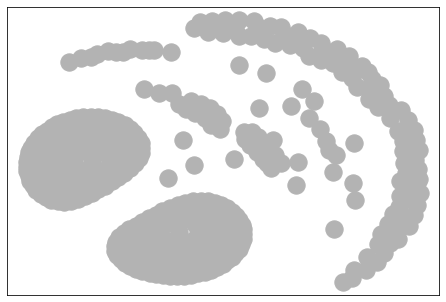

In [11]:
import json

def visualize_graph(g):
  nx_G = g.to_networkx().to_undirected()
  
  # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
  pos = nx.kamada_kawai_layout(nx_G)
  nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])


jsonGraph = json.loads(jsonstr)
g = dgl.graph((jsonGraph["SourceNodes"], jsonGraph["DestinationNodes"]), num_nodes=jsonGraph["NumNodes"])
visualize_graph(g)

In [119]:
g = dgl.to_bidirected(g)
g

Graph(num_nodes=366, num_edges=730,
      ndata_schemes={}
      edata_schemes={})

In [12]:
# featureList.Add(feature.ID);
# featureList.Add(feature.typeID);

# featureList.Add(feature.absPos.x);
# featureList.Add(feature.absPos.y);
# featureList.Add(feature.absPos.z);

# featureList.Add(feature.absRot.x);
# featureList.Add(feature.absRot.y);
# featureList.Add(feature.absRot.z);
# featureList.Add(feature.absRot.w);

# featureList.Add(feature.absScale.x);
# featureList.Add(feature.absScale.y);
# featureList.Add(feature.absScale.z);

# featureList.Add(feature.locPos.x);
# featureList.Add(feature.locPos.y);
# featureList.Add(feature.locPos.z);

# featureList.Add(feature.locRot.x);
# featureList.Add(feature.locRot.y);
# featureList.Add(feature.locRot.z);
# featureList.Add(feature.locRot.w);

# featureList.Add(feature.locScale.x);
# featureList.Add(feature.locScale.y);
# featureList.Add(feature.locScale.z);

In [29]:
from dataclasses import dataclass

@dataclass
class GraphNode:
    """Class for keeping track of features of a Graph Node."""
    gameobjectID: int
    typeID: int
    
    abs_pos: np.array
    abs_rot: np.array
    abs_scale: np.array

    loc_pos: np.array
    loc_rot: np.array
    loc_scale: np.array
        
    rel_agent_pos: np.array
    rel_goal_pos: np.array
        
def JsonToGraphNode(JSON_list:list, agent_features, goal_features)-> GraphNode:
    gameobjectID = JSON_list[0]
    typeID = JSON_list[1]
            
    abs_pos = np.array(JSON_list[2:5])
    abs_rot = np.array(JSON_list[5:9])
    abs_scale = np.array(JSON_list[9:12])

    loc_pos = np.array(JSON_list[12:15])
    loc_rot = np.array(JSON_list[15:19])
    loc_scale = np.array(JSON_list[19:22])
    
    agent_pos = np.array(agent_features[2:5])
    goal_pos  = np.array(goal_features[2:5])
    
    rel_agent_pos = agent_pos - abs_pos  
    rel_goal_pos  = goal_pos - abs_pos

    return GraphNode(gameobjectID=gameobjectID,
                     typeID=typeID,
                     
                     abs_pos=abs_pos,
                     abs_rot=abs_rot,
                     abs_scale=abs_scale,

                     loc_pos=loc_pos,
                     loc_rot=loc_rot,
                     loc_scale=loc_scale, 
                    
                     rel_agent_pos=rel_agent_pos,
                     rel_goal_pos=rel_goal_pos)

In [33]:
JsonToGraphNode(jsonGraph["Features"][3], jsonGraph["Features"][0], jsonGraph["Features"][1])

GraphNode(gameobjectID=3.0, typeID=3.0, abs_pos=array([  0., -35.,   0.]), abs_rot=array([0., 0., 0., 1.]), abs_scale=array([91.    ,  4.1258, 91.    ]), loc_pos=array([  0., -50.,   0.]), loc_rot=array([0., 0., 0., 1.]), loc_scale=array([130.   ,   5.894, 130.   ]), rel_agent_pos=array([ 0., 35.,  0.]), rel_goal_pos=array([ 0., 35.,  0.]))

In [108]:
@dataclass
class AllGraphNodes:
    """Class for keeping track of features of a Graph Features."""
    gameobjectIDs: np.array
    typeIDs: np.array
        
    rel_agent_poss: np.array
    rel_goal_poss: np.array
    
    abs_poss: np.array
    abs_rots: np.array
    abs_scales: np.array

    loc_poss: np.array
    loc_rots: np.array
    loc_scales: np.array
        
    rel_agent_poss: np.array
    rel_goal_poss: np.array
        
    def update_rel_goal_pos(self, goal_pos:np.array):
        self.rel_goal_poss = goal_pos - self.abs_poss
    
    def update_rel_agent_pos(self, agent_pos:np.array):
        self.rel_agent_poss = agent_pos - self.abs_poss
        
    def normalize(self):
        def normalize(v):
            return v / np.abs(v).max()
        
        self.gameobjectIDs = normalize(self.gameobjectIDs)
        self.typeIDs = normalize(self.typeIDs)

        self.rel_agent_poss = normalize( self.rel_agent_poss)
        self.rel_goal_poss = normalize(self.rel_goal_poss)

        self.abs_poss = normalize(self.abs_poss)
        self.abs_rots = normalize(self.abs_rots)
        self.abs_scales = normalize(self.abs_scales)

        self.loc_poss = normalize(self.loc_poss)
        self.loc_rots = normalize(self.loc_rots)
        self.loc_scales = normalize(self.loc_scales)

        self.rel_agent_poss = normalize(self.rel_agent_poss)
        self.rel_goal_poss = normalize(self.rel_goal_poss)
        
        
    def JsonToAllGraphNodes(JSON_list:list, normalize=True)-> AllGraphNodes:
        JSON_array = np.array(JSON_list)
        agent_features = np.array(JSON_list[0])
        goal_features  = np.array(JSON_list[1])

        gameobjectIDs = JSON_array[:,0]
        typeIDs = JSON_array[:,1]

        abs_poss = np.array(JSON_array[:,2:5])
        abs_rots = np.array(JSON_array[:,5:9])
        abs_scales = np.array(JSON_array[:,9:12])

        loc_poss = np.array(JSON_array[:,12:15])
        loc_rots = np.array(JSON_array[:,15:19])
        loc_scales = np.array(JSON_array[:,19:22])

        agent_pos = agent_features[2:5]
        goal_pos = goal_features[2:5]

        rel_agent_poss = agent_pos - abs_poss  
        rel_goal_poss  = goal_pos - abs_poss

        allNodes= AllGraphNodes(gameobjectIDs=gameobjectIDs,
                         typeIDs=typeIDs,

                         abs_poss=abs_poss,
                         abs_rots=abs_rots,
                         abs_scales=abs_scales,

                         loc_poss=loc_poss,
                         loc_rots=loc_rots,
                         loc_scales=loc_scales, 

                         rel_agent_poss=rel_agent_poss,
                         rel_goal_poss=rel_goal_poss)
        
        if normalize:
            allNodes.normalize()
            
        return allNodes


In [116]:
allnodes = AllGraphNodes.JsonToAllGraphNodes(jsonGraph["Features"])

In [14]:
g.ndata["feat"] = th.tensor(jsonGraph["Features"])[:,   4:]
g.ndata["label"] = th.tensor(jsonGraph["Features"])[:, 1:4]
g.ndata["train_mask"] = th.tensor(train_mask)
g.ndata["val_mask"] = th.tensor(val_mask)

In [15]:
g.ndata["feat"].shape

torch.Size([364, 3])

In [16]:

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats=32, embedding_size=16):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv_hid = GraphConv(h_feats, h_feats)
        self.conv2 = GraphConv(h_feats, 64)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv_hid(g, h)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


In [17]:
np.array(jsonGraph["Features"]).shape

(364, 7)

In [18]:
g = dgl.graph((jsonGraph["SourceNodes"], jsonGraph["DestinationNodes"]), num_nodes=jsonGraph["NumNodes"])
g

Graph(num_nodes=364, num_edges=363,
      ndata_schemes={}
      edata_schemes={})

In [19]:
class AggregateGCN(nn.Module):
    def __init__(self, in_dim, h_feats=32, embedding_size=16):
        super(AggregateGCN, self).__init__()
        self.conv1 = GraphConv(in_dim, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.embedding = nn.Linear(h_feats, embedding_size)

    def forward(self, g, h):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            
            g.ndata['h'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'h')
            return self.embedding(hg)
        


In [20]:
g = dgl.graph((jsonGraph["SourceNodes"], jsonGraph["DestinationNodes"]), num_nodes=jsonGraph["NumNodes"])
g = dgl.add_self_loop(g)
def get_GNN_batch(graph_data, batch):

    graphs = []
    for obs in batch:
        g = dgl.graph((jsonGraph["SourceNodes"], jsonGraph["DestinationNodes"]), num_nodes=jsonGraph["NumNodes"])
        g = dgl.add_self_loop(g)
        new_features = []
        for features in jsonGraph["Features"]:
            dist_to_agent = obs[slice_dict["AgentPosition"]] - features[1:4]
            dist_to_goal  = obs[slice_dict["GoalPosition" ]] - features[1:4]
            new_features.append(np.append(dist_to_agent, dist_to_goal))
        g.ndata["feat"] = th.tensor(new_features).float()
        graphs.append(g)
    return graphs


In [21]:
!pip install line_profiler

In [22]:
%load_ext line_profiler

In [23]:
slice_dict =  {
    "CanSeeGoal": slice(0,1),
    "Direction" : slice(1,4),
    "DirectionNormalized": slice(4,7),
    "MagnitudeNormalized": slice(7,8),
    "RemainingJumpCount" : slice(8,9),
    "Velocity": slice(9,12),
    "IsGrounded": slice(12,13),
    "AgentPosition": slice(13,16),
    "GoalPosition": slice(16,19),
    "AgentGoalPosition": slice(13,19),
}

In [24]:
from copy import deepcopy

In [25]:
g = dgl.graph((jsonGraph["SourceNodes"], jsonGraph["DestinationNodes"]), num_nodes=jsonGraph["NumNodes"], device =torch.device("cuda:0"))
g = dgl.add_self_loop(g)
def get_GNN_batch_copy(jsonGraph, features_batch):
    global g
    graphs = []
    for obs in features_batch:
        g = deepcopy(g)
        g.to(th.device('cuda:0'))
        new_features = []
        for features in jsonGraph["Features"]:
            dist_to_agent = obs[slice_dict["AgentPosition"]] - th.tensor(features[1:4], device="cuda:0")
            dist_to_goal  = obs[slice_dict["GoalPosition" ]] - th.tensor(features[1:4], device="cuda:0")
            new_features.append(th.cat([dist_to_agent, dist_to_goal], dim=0))
        g.ndata["feat"] = th.stack(new_features)
        graphs.append(g)
    return dgl.batch(graphs)

In [26]:
batch_tn = th.tensor(observations[0:32]).cuda()
feats = get_GNN_batch_copy(jsonGraph, batch_tn)

In [27]:
def get_GNN_batch(jsonGraph, features_batch):
        graphs = []
        for obs in features_batch:
            g = dgl.graph((jsonGraph["SourceNodes"], jsonGraph["DestinationNodes"]), num_nodes=jsonGraph["NumNodes"], device =torch.device("cuda:0"))
            g = dgl.add_self_loop(g)
            g.to(th.device('cuda:0'))
            new_features = []
            for features in jsonGraph["Features"]:
                dist_to_agent = obs[slice_dict["AgentPosition"]] - th.tensor(features[1:4], device="cuda:0")
                dist_to_goal  = obs[slice_dict["GoalPosition" ]] - th.tensor(features[1:4], device="cuda:0")
                new_features.append(th.cat([dist_to_agent, dist_to_goal], dim=0))
            g.ndata["feat"] = th.stack(new_features)
            graphs.append(g)
        return dgl.batch(graphs)

In [28]:
g = dgl.graph((jsonGraph["SourceNodes"], jsonGraph["DestinationNodes"]), num_nodes=jsonGraph["NumNodes"], device =torch.device("cuda:0"))
g = dgl.add_self_loop(g)
def get_GNN_batch_opt(jsonGraph, features_batch):
    scene_graph_features = np.array(jsonGraph["Features"])
    scene_graph_selected_features = np.concatenate([scene_graph_features[:,1:4],scene_graph_features[:,1:4]], axis=1)    
    global g
    new_features = np.array([obs[slice_dict["AgentGoalPosition"]] - scene_graph_selected_features for obs in features_batch])

    graphs = []
    for i in range(features_batch.shape[0]):
        g = deepcopy(g)
        g.to(th.device('cuda:0'))
        g.ndata["feat"] = th.tensor(new_features[i], device="cuda:0")
        graphs.append(g)
    return dgl.batch(graphs)

In [29]:
from functools import partial
g = dgl.graph((jsonGraph["SourceNodes"], jsonGraph["DestinationNodes"]), num_nodes=jsonGraph["NumNodes"], device =torch.device("cuda:0"))
g = dgl.add_self_loop(g)
graph_list = [deepcopy(g) for _ in range(32)]
def get_GNN_batch_opt_vec(jsonGraph, features_batch):
    global g
    def create_graph_from_feature(feature, g):
        g.to(th.device('cuda:0'))
        g.ndata["feat"] = th.tensor(feature, device="cuda:0")
        return g
        
    scene_graph_features = np.array(jsonGraph["Features"])
    scene_graph_selected_features = np.concatenate([scene_graph_features[:,1:4],scene_graph_features[:,1:4]], axis=1)    

    new_features = np.array([obs[slice_dict["AgentGoalPosition"]] - scene_graph_selected_features for obs in features_batch])
    
    partial(create_graph_from_feature, )
    graphs = [create_graph_from_feature(g, feature) for feature in new_features]
    return dgl.batch(graphs)

In [31]:
batch = observations[0:32]
scene_graph_features = np.array(jsonGraph["Features"])
scene_graph_features[:,1:4]

array([[  0.       ,   0.       ,   0.       ],
       [  0.       , -35.       ,   0.       ],
       [ 10.6145983,  -0.7      ,  37.8      ],
       ...,
       [ 16.7045975,   1.75     , -21.6999989],
       [ 34.6499977,   0.       ,  38.1499977],
       [-26.7829037,  -4.83     ,   0.       ]])

In [36]:
get_GNN_batch_opt(jsonGraph, batch).ndata["feat"].max()

tensor(72.3793, device='cuda:0', dtype=torch.float64)

In [38]:
observations[:,slice_dict["AgentGoalPosition"]].min()

-0.31914937

In [83]:
scene_graph_selected_features = np.concatenate([scene_graph_features[:,1:4],scene_graph_features[:,1:4]], axis=1)

In [92]:
new_features = np.array([obs[slice_dict["AgentGoalPosition"]] - scene_graph_selected_features for obs in batch])

(505,)

In [ ]:
new_features = []
for features in jsonGraph["Features"]:
    dist_to_agent = obs[slice_dict["AgentPosition"]] - th.tensor(features[1:4], device="cuda:0")
    dist_to_goal  = obs[slice_dict["GoalPosition" ]] - th.tensor(features[1:4], device="cuda:0")
    new_features.append(th.cat([dist_to_agent, dist_to_goal], dim=0))

In [85]:
%timeit get_GNN_batch(jsonGraph, batch_tn)

2.28 s ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%timeit get_GNN_batch_copy(jsonGraph, batch_tn)

2.27 s ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
%timeit get_GNN_batch_opt(jsonGraph, batch)

29.7 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [122]:
%timeit get_GNN_batch_opt_vec(jsonGraph, batch)

31.1 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%lprun -f get_GNN_batch_copy get_GNN_batch_copy(jsonGraph, batch_tn)

In [ ]:
get_GNN_batch(jsonGraph, batch_tn)

In [ ]:
grapharr = get_GNN_batch(jsonGraph, batch)

In [ ]:
graph_batch = dgl.batch(grapharr)

In [ ]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [ ]:
# gmodel = GCN(6)
gmodel = AggregateGCN(6)
gmodel(graph_batch, graph_batch.ndata["feat"])

In [ ]:
slice_obj = slice(0,15)
observations[:, slice_obj].shape

In [ ]:
observations[:, slice_dict["AgentPosition"]].min(0) * 141

In [ ]:
batch_obs = th.tensor(observations[0:32])

In [ ]:
batch_graph = gmodel(graph_batch, graph_batch.ndata["feat"])

In [ ]:
class AggregateGCN(nn.Module):
    def __init__(self, in_dim, h_feats=32, embedding_size=16):
        super(AggregateGCN, self).__init__()
        self.conv1 = GraphConv(in_dim, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.embedding = nn.Linear(h_feats, embedding_size)

    def forward(self, g, h):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata['h'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'h')
            return self.embedding(hg)
        
class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the feature extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super(CustomNetwork, self).__init__()
        
        jsonstr = """{"SourceNodes":[0,0,0,0,0,0,6,7,7,7,7,7,7,7,7,6,16,16,16,16,16,16,16,16,16,16,0,27,27,27,27,0,32,33,33,33,33,33,33,33,33,32,42,42,42,42,42,42,42,42,42,42,32,53,53,53,53,53,53,53,53,53,53,32,64,64,64,64,64,64,64,64,64,64,64,64,0,77,77,79,79,79,79,79,79,79,79,79,79,79,90,90,90,79,94,94,94,94,94,94,79,101,101,101,79,77,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,77,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,0,330,331,331,331,331,331,331,331,331,330,340,340,340,340,340,340,340,340,340,340,340,340,340,0,0,0,0,0,358,358,360,0,0],"DestinationNodes":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363],"NumNodes":364,"Features":[[0.0,0.0,0.0,0.0,0.0,0.0,0.0],[1.0,0.0,-35.0,0.0,0.0,-50.0,0.0],[2.0,10.6145983,-0.7,37.8,15.1637115,-1.0,54.0],[3.0,2.38959742,-0.7,0.0,3.41371059,-1.0,0.0],[4.0,27.9045963,-8.749999,-16.304821,39.86371,-12.499999,-23.2926],[5.0,-26.7829037,-8.75,0.0,-38.26129,-12.5,0.0],[6.0,0.9545973,0.0,-2.1,1.3637104,0.0,-3.0],[7.0,0.9545973,0.0,-2.1,0.0,0.0,0.0],[8.0,28.9545956,4.375,-44.1,-40.0,6.25,60.0],[9.0,28.9545956,4.375,-30.1,-40.0,6.25,40.0],[10.0,28.9545956,6.125,-37.1,-40.0,8.75,50.0],[11.0,37.0045967,4.375,-45.1499977,-51.5,6.25,61.5],[12.0,45.0545959,4.375,-37.1,-63.0,6.25,50.0],[13.0,37.0045967,4.375,-29.05,-51.5,6.25,38.5],[14.0,41.9045944,3.5,-37.1,-58.5,5.0,50.0],[15.0,32.1045952,8.4,-37.1,-44.5,12.0,50.0],[16.0,73.0552444,8.75,-72.09946,103.000931,12.5,-99.99922],[17.0,28.9546547,13.125,-30.0999031,-63.00013,6.25,60.00011],[18.0,28.9548244,13.125,-44.0999031,-63.00013,6.25,40.00011],[19.0,28.95474,16.1,-37.0999031,-63.00013,10.5,50.00011],[20.0,45.0547829,13.125,-37.09979,-40.0000725,6.25,50.0],[21.0,37.0049248,13.125,-45.1498833,-51.5,6.25,38.5],[22.0,41.9045944,12.25,-37.0999451,-44.5003357,5.0,49.99983],[23.0,33.4298325,17.15,-37.0998268,-56.60714,12.0,50.000145],[24.0,30.004734,13.125,-29.0499134,-61.5,6.25,61.5000763],[25.0,44.004734,13.125,-29.0497456,-41.5,6.25,61.50008],[26.0,37.004734,16.8874989,-29.0498314,-51.5,11.625,61.5000763],[27.0,0.0,0.0,0.0,0.0,0.0,0.0],[28.0,-52.5,14.0,0.0,-75.0,20.0,0.0],[29.0,52.5,14.0,0.0,75.0,20.0,0.0],[30.0,0.0,14.0,52.5,0.0,20.0,75.0],[31.0,0.0,14.0,-52.5,0.0,20.0,-75.0],[32.0,-38.2499962,0.0,41.2500267,-54.6428528,0.0,58.9286079],[33.0,5.849971,0.0,-2.49984622,62.9999542,0.0,-62.4998169],[34.0,-22.1500282,4.375,39.5001526,-40.0,6.25,60.0],[35.0,-22.1500282,4.375,25.5001526,-40.0,6.25,40.0],[36.0,-22.1500282,6.125,32.5001526,-40.0,8.75,50.0],[37.0,-30.20003,4.375,40.55015,-51.5,6.25,61.5],[38.0,-38.2500267,4.375,32.5001526,-63.0,6.25,50.0],[39.0,-30.20003,4.375,24.4501534,-51.5,6.25,38.5],[40.0,-35.10003,3.5,32.5001526,-58.5,5.0,50.0],[41.0,-25.3000278,8.4,32.5001526,-44.5,12.0,50.0],[42.0,-65.2,8.75,-3.54997444,-38.5,12.5,-64.0],[43.0,-23.200079,13.125,24.4501476,-40.0,6.25,60.0],[44.0,-37.20008,13.125,24.4501076,-40.0,6.25,40.0],[45.0,-30.200079,16.1,24.4501266,-40.0,10.5,50.0],[46.0,-30.2001247,13.125,40.5501251,-63.0,6.25,50.0],[47.0,-38.2501,13.125,32.500103,-51.5,6.25,38.5],[48.0,-30.2001171,12.25,37.4001274,-58.5,5.0,50.0],[49.0,-30.2000866,17.15,27.6001263,-44.5,12.0,50.0],[50.0,-22.1500683,13.125,39.50015,-61.5,6.25,61.5000763],[51.0,-22.1500263,13.125,25.5001488,-41.5,6.25,61.50008],[52.0,-22.1500473,16.1,32.50015,-51.5,10.5,61.5000763],[53.0,-66.25028,17.5,67.49997,-40.000412,25.0,37.4999237],[54.0,-22.1499462,21.875,25.5001526,-63.00013,6.25,60.00011],[55.0,-22.1500282,21.875,39.5001526,-63.00013,6.25,40.00011],[56.0,-22.1499882,24.85,32.5001526,-63.00013,10.5,50.00011],[57.0,-38.2500267,21.875,32.5001373,-40.0000725,6.25,50.0],[58.0,-30.2001247,21.875,40.5501862,-51.5,6.25,38.5],[59.0,-25.30008,21.0,32.5002136,-58.5,5.0,50.0],[60.0,-35.10008,25.9,32.5001564,-44.5,12.0,50.0],[61.0,-23.2000313,21.875,24.4501724,-61.5,6.25,61.5000763],[62.0,-37.20003,21.875,24.4500866,-41.5,6.25,61.50008],[63.0,-30.2000313,24.85,24.4501324,-51.5,10.5,61.5000763],[64.0,-65.2,26.25,-3.54997444,-38.5,37.5,-64.0],[65.0,-23.200079,30.625,24.4501476,-40.0,6.25,60.0],[66.0,-37.20008,30.625,24.4501076,-40.0,6.25,40.0],[67.0,-30.200079,34.475,24.4501266,-40.0,11.75,50.0],[68.0,-30.2001247,30.625,40.5501251,-63.0,6.25,50.0],[69.0,-30.2001171,29.75,37.4001274,-58.5,5.0,50.0],[70.0,-26.0750923,34.6499977,32.5001564,-51.5000229,12.0,55.892868],[71.0,-22.1500683,30.625,39.50015,-61.5,6.25,61.5000763],[72.0,-22.1500263,30.625,25.5001488,-41.5,6.25,61.50008],[73.0,-22.1500473,34.6499977,32.50015,-51.5,12.0,61.5000763],[74.0,-38.2499962,30.625,39.5001068,-61.5000038,6.25,38.50018],[75.0,-38.2500267,30.625,25.500103,-41.4999962,6.25,38.5000763],[76.0,-38.2499962,34.6499977,32.5001,-51.4999962,12.0,38.50015],[77.0,5.329597,0.0,-62.3,7.6137104,0.0,-89.0],[78.0,-42.6204033,0.0,18.9,-68.5,0.0,116.0],[79.0,2.17959714,0.0,-72.1,-4.5,0.0,-14.0],[80.0,-17.7704029,8.749999,-44.1,-28.5,12.499999,40.0],[81.0,-17.7704029,6.65,-36.925,-28.5,9.5,50.25],[82.0,-37.0204048,4.375,-29.05,-56.0,6.25,61.5],[83.0,-45.0704041,4.375,-17.5,-67.5,6.25,78.0],[84.0,-31.4204044,8.749999,-45.1499977,-48.0,12.499999,38.5],[85.0,-40.1704025,3.5,-37.1,-60.5,5.0,50.0],[86.0,-31.7704029,6.73749971,10.15,-48.5,9.625,117.5],[87.0,-17.7704029,4.375,-10.32501,-28.5,6.25,88.2499847],[88.0,-37.0204048,4.375,10.15,-56.0,6.25,117.5],[89.0,-31.5954037,8.4,-9.450006,-48.25,11.999999,89.49999],[90.0,2.17959714,0.0,-71.75,0.0,0.0,0.5],[91.0,-17.7704182,13.125,4.4625,-28.5000229,18.75,108.875],[92.0,-17.7704029,16.1,2.1,-28.5,23.0,105.5],[93.0,-17.7704029,9.1875,-10.325,-28.4999981,13.125,87.75],[94.0,2.17959714,0.0,-71.75,0.0,0.0,0.5],[95.0,-17.7704182,13.125,9.099999,-28.5000229,18.75,115.5],[96.0,-17.7703781,13.125,-29.75,-28.4999657,18.75,60.0],[97.0,-17.7704029,16.1,-10.325,-28.4999981,23.0,87.75],[98.0,-17.7703781,13.125,-17.15,-28.4999657,18.75,78.0],[99.0,-45.0704041,13.125,-17.5,-67.5,18.75,77.5],[100.0,-30.3677444,9.275,10.15,-46.4962,13.25,117.0],[101.0,36.8295937,0.0,30.1,49.5,0.0,146.0],[102.0,-44.020462,13.125,10.150219,-28.5000229,18.75,115.5],[103.0,-30.2829628,16.1,10.150197,-28.5,23.0,95.875],[104.0,-28.6204624,13.125,10.185194,-28.45,18.75,93.5],[105.0,-14.6204023,9.4,-9.575023,-24.0,13.4285707,89.3213959],[106.0,5.329597,0.0,-62.3,0.0,0.0,0.0],[107.0,-42.4796143,0.350000322,-12.2789774,-68.2988739,0.5000005,71.4586],[108.0,-44.1787872,1.02814519,-6.062579,-70.726265,1.46877885,80.33917],[109.0,-43.9167,0.349999875,-3.40537572,-70.35185,0.499999821,84.13518],[110.0,-44.1803551,0.350000083,-8.472802,-70.7285,0.5000001,76.8959961],[111.0,-43.4541435,0.429832876,-5.629256,-69.6910553,0.614047,80.9582062],[112.0,-42.77045,0.4150438,-6.98568726,-68.7143555,0.5929197,79.02045],[113.0,-44.36704,0.3500023,-7.35342836,-70.99519,0.5000033,78.4951],[114.0,-41.9270668,0.3574566,-7.134967,-67.50952,0.5106523,78.80719],[115.0,-43.881115,0.3499344,-6.45493,-70.30102,0.499906272,79.77867],[116.0,-36.96356,0.35,-6.13710165,-60.4187965,0.5,80.23271],[117.0,-40.7084465,0.350001037,-4.05958557,-65.76863,0.5000015,83.20059],[118.0,-43.61579,1.23395753,-6.813763,-69.92198,1.76279652,79.26605],[119.0,-43.1038,0.7464877,-8.207322,-69.19057,1.066411,77.27525],[120.0,-40.20888,0.350000173,-8.098396,-65.05497,0.500000238,77.43086],[121.0,-38.131916,0.350000441,-6.268266,-62.08788,0.500000656,80.0453339],[122.0,-33.0352058,0.350000024,-6.62743044,-54.80686,0.50000006,79.53224],[123.0,-31.12954,0.3500002,-6.153604,-52.0844841,0.5000003,80.20914],[124.0,-32.017,0.3500001,-6.54766369,-53.35228,0.5000002,79.6461945],[125.0,-34.205513,0.350000024,-7.39778757,-56.4787331,0.50000006,78.43173],[126.0,-39.8703842,0.450290382,-6.06184244,-64.5714,0.643272,80.3402252],[127.0,-42.6923,0.49535504,-10.2777567,-68.60271,0.707650065,74.31749],[128.0,-28.4589577,1.19564021,-3.8241837,-48.2693672,1.7080574,83.53688],[129.0,-35.4733276,1.09330356,-8.387012,-58.2898979,1.56186223,77.0185547],[130.0,-27.5609341,1.18526852,-4.463472,-46.9864731,1.69324076,82.62361],[131.0,-26.5005264,0.350169182,-4.835774,-45.4716034,0.5002417,82.09175],[132.0,-24.43534,0.8272036,-1.77926636,-42.52134,1.18171942,86.45819],[133.0,-22.901619,0.349729747,-0.3232971,-40.330307,0.4996139,88.53815],[134.0,-24.6071587,1.05004644,-5.75976849,-42.7667923,1.5000664,80.77176],[135.0,-22.894783,1.05008852,-5.50895357,-40.32054,1.50012648,81.1300659],[136.0,-19.29491,2.44970322,-5.510962,-35.1778679,3.499576,81.1272],[137.0,-18.53671,1.05046582,-5.55458355,-34.0947266,1.50066555,81.06488],[138.0,-35.8468323,1.05000043,-3.68874669,-58.82347,1.50000072,83.73036],[139.0,-36.75868,1.05,-13.090745,-60.1261063,1.5,70.2989349],[140.0,-20.568491,1.05000746,-6.52805328,-36.99727,1.50001073,79.67421],[141.0,-20.8980446,1.73186743,-1.90715182,-37.46806,2.4740963,86.2755],[142.0,-22.2030334,3.150025,-6.4850297,-39.33233,4.500036,79.73567],[143.0,-20.218235,3.93528032,-3.80003357,-36.4969025,5.621829,83.57138],[144.0,-39.848793,0.350000322,2.57730865,-64.54056,0.5000005,92.68187],[145.0,-34.3033257,1.02814519,5.8604064,-56.61846,1.46877885,97.37201],[146.0,-31.6714649,0.349999815,6.31059551,-52.8586578,0.499999762,98.01514],[147.0,-36.6281128,0.35,5.22432232,-59.9395828,0.5,96.46332],[148.0,-33.6937523,0.429832935,5.276222,-55.7476425,0.61404705,96.53746],[149.0,-34.82101,0.415043861,4.258052,-57.35801,0.5929198,95.08293],[150.0,-35.598,0.350002319,5.7004776,-58.468,0.500003338,97.14354],[151.0,-34.74185,0.3574566,3.4052155,-57.2449265,0.5106523,93.86459],[152.0,-34.60297,0.3499344,5.469551,-57.046524,0.4999063,96.8136444],[153.0,-32.4665146,0.35,-1.1174835,-53.9944458,0.5,87.403595],[154.0,-31.4536648,0.350001,3.043573,-52.5475159,0.500001431,93.34796],[155.0,-34.8788223,1.23395753,5.118739,-57.4405975,1.76279652,96.3124847],[156.0,-36.0872879,0.7464877,4.256354,-59.1669769,1.066411,95.0805054],[157.0,-35.2164536,0.350000173,1.49338531,-57.9229279,0.500000238,91.13341],[158.0,-32.90206,0.3500005,-0.0254638661,-54.6166573,0.5000007,88.96362],[159.0,-31.9001751,0.35,-5.035608,-53.1853867,0.5,81.8062744],[160.0,-30.939106,0.350000173,-6.748042,-51.8124352,0.500000238,79.35994],[161.0,-31.5539017,0.350000173,-5.99644136,-52.690712,0.500000238,80.4336548],[162.0,-32.9526749,0.35,-4.11078024,-54.6889572,0.5,83.12746],[163.0,-33.16288,0.450290352,1.70567322,-54.98925,0.6432719,91.436676],[164.0,-37.9751167,0.495355129,3.31180882,-61.8638763,0.7076502,93.7311554],[165.0,-27.9861889,1.19564021,-8.707265,-47.59398,1.7080574,76.56105],[166.0,-34.24205,1.09330356,-3.14981842,-56.5309258,1.56186223,84.50026],[167.0,-28.3651447,1.18526852,-9.742407,-48.1353455,1.69324076,75.0822754],[168.0,-28.4436741,0.3501692,-10.863533,-48.2475281,0.500241756,73.48067],[169.0,-24.9497356,0.8272035,-12.0465879,-43.25619,1.1817193,71.79059],[170.0,-23.1398945,0.3497298,-13.1405191,-40.6707,0.499614,70.22783],[171.0,-28.8338833,1.05004632,-12.9338923,-48.8049736,1.50006628,70.52301],[172.0,-28.1390038,1.05008841,-14.5189114,-47.81229,1.50012636,68.2587],[173.0,-27.1886425,2.44970322,-17.991066,-46.45463,3.499576,63.2984772],[174.0,-27.0301456,1.050466,-18.73379,-46.2282066,1.50066566,62.237442],[175.0,-29.8099575,1.05000043,-1.546759,-50.1993637,1.50000072,86.7903442],[176.0,-39.11823,1.05,-3.1545608,-63.4968948,1.5,84.4934845],[177.0,-28.5064259,1.05000746,-17.031908,-48.3371735,1.50001073,64.6687],[178.0,-24.13731,1.73186743,-15.4917078,-42.09558,2.4740963,66.86899],[179.0,-28.8973236,3.150025,-15.44422,-48.8956,4.500036,66.93683],[180.0,-25.7829189,3.93528032,-16.6480274,-44.44645,5.621829,65.2171],[181.0,-30.0344,0.350000322,-0.8470047,-50.52,0.5000005,87.78999],[182.0,-24.3391953,1.02814519,-3.86286,-42.3839874,1.46877885,83.48163],[183.0,-22.5812645,0.349999815,-5.87260437,-39.8726578,0.499999762,80.6105652],[184.0,-26.0953732,0.35,-2.2120986,-44.8928146,0.5,85.83986],[185.0,-24.51922,0.429832935,-4.68775463,-42.64117,0.61404705,82.30321],[186.0,-25.9761238,0.415043861,-4.25782776,-44.72246,0.5929198,82.91739],[187.0,-25.1514912,0.350002319,-2.84211564,-43.54441,0.500003338,84.9398346],[188.0,-26.6621952,0.3574566,-4.77056551,-45.70256,0.5106523,82.184906],[189.0,-24.8289852,0.3499344,-3.81133413,-43.0836868,0.4999063,83.55524],[190.0,-29.3318386,0.35,-9.072314,-49.5163345,0.5,76.03955],[191.0,-25.2540512,0.350001,-7.763916,-43.6909256,0.500001431,77.90869],[192.0,-25.27221,1.23395753,-3.75919938,-43.7168655,1.76279652,83.629715],[193.0,-26.6386337,0.7464877,-3.17870021,-45.6689,1.066411,84.459],[194.0,-28.5405788,0.350000173,-5.36385,-48.3859673,0.500000238,81.33736],[195.0,-28.6278057,0.3500005,-8.13075,-48.51058,0.5000007,77.38464],[196.0,-32.378006,0.35,-11.60081,-53.8680077,0.5,72.4274139],[197.0,-33.33683,0.350000173,-13.3144941,-55.23776,0.500000238,69.9792938],[198.0,-33.0167274,0.350000173,-12.3977633,-54.7804642,0.500000238,71.28891],[199.0,-32.1386528,0.35,-10.220314,-53.52607,0.5,74.39955],[200.0,-27.28746,0.450290352,-7.00453949,-46.5957947,0.6432719,78.993515],[201.0,-28.4297886,0.495355129,-2.06163335,-48.22769,0.7076502,86.05481],[202.0,-33.4663124,1.19564021,-16.8558941,-55.4227333,1.7080574,64.92015],[203.0,-31.99216,1.09330356,-8.61891,-53.3167953,1.56186223,76.68727],[204.0,-34.5470428,1.18526852,-17.0730743,-56.9666328,1.69324076,64.60989],[205.0,-35.54426,0.3501692,-17.5913773,-58.3912239,0.500241756,63.86946],[206.0,-34.72929,0.8272035,-21.189024,-57.2269859,1.1817193,58.7299652],[207.0,-34.7175,0.3497298,-23.3037529,-57.2101364,0.499614,55.7089233],[208.0,-37.5138,1.05004632,-18.3394,-61.2048569,1.50006628,62.8008575],[209.0,-38.5029259,1.05008841,-19.7595329,-62.6178932,1.50012636,60.7720947],[210.0,-40.9682579,2.44970322,-22.3827381,-66.13979,3.499576,57.02466],[211.0,-41.51899,1.050466,-22.9056664,-66.92655,1.50066566,56.27762],[212.0,-28.3111153,1.05000043,-11.5622406,-48.05816,1.50000072,72.48251],[213.0,-34.5418167,1.05,-4.462425,-56.95916,1.5,82.62511],[214.0,-40.8381157,1.05000746,-20.7580719,-65.95387,1.50001073,59.34561],[215.0,-37.24356,1.73186743,-23.6804771,-60.8187943,2.4740963,55.1707458],[216.0,-39.6880264,3.150025,-19.5958118,-64.31089,4.500036,61.00598],[217.0,-39.0888939,3.93528032,-22.8805771,-63.45499,5.621829,56.31346],[218.0,5.329597,8.75,-62.3,0.0,12.5,0.0],[219.0,-42.4796143,9.099999,-12.2789774,-68.2988739,0.5000005,71.4586],[220.0,-44.1787872,9.778145,-6.062579,-70.726265,1.46877885,80.33917],[221.0,-43.9167,9.099999,-3.40537572,-70.35185,0.499999821,84.13518],[222.0,-44.1803551,9.099999,-8.472802,-70.7285,0.5000001,76.8959961],[223.0,-43.4541435,9.179832,-5.629256,-69.6910553,0.614047,80.9582062],[224.0,-42.77045,9.165044,-6.98568726,-68.7143555,0.5929197,79.02045],[225.0,-44.36704,9.100002,-7.35342836,-70.99519,0.5000033,78.4951],[226.0,-41.9270668,9.107456,-7.134967,-67.50952,0.5106523,78.80719],[227.0,-43.881115,9.099935,-6.45493,-70.30102,0.499906272,79.77867],[228.0,-36.96356,9.099999,-6.13710165,-60.4187965,0.5,80.23271],[229.0,-40.7084465,9.100001,-4.05958557,-65.76863,0.5000015,83.20059],[230.0,-43.61579,9.983957,-6.813763,-69.92198,1.76279652,79.26605],[231.0,-43.1038,9.496488,-8.207322,-69.19057,1.066411,77.27525],[232.0,-40.20888,9.099999,-8.098396,-65.05497,0.500000238,77.43086],[233.0,-38.131916,9.1,-6.268266,-62.08788,0.500000656,80.0453339],[234.0,-33.0352058,9.099999,-6.62743044,-54.80686,0.50000006,79.53224],[235.0,-31.12954,9.099999,-6.153604,-52.0844841,0.5000003,80.20914],[236.0,-32.017,9.099999,-6.54766369,-53.35228,0.5000002,79.6461945],[237.0,-34.205513,9.099999,-7.39778757,-56.4787331,0.50000006,78.43173],[238.0,-39.8703842,9.200291,-6.06184244,-64.5714,0.643272,80.3402252],[239.0,-42.6923,9.245355,-10.2777567,-68.60271,0.707650065,74.31749],[240.0,-28.4589577,9.94564,-3.8241837,-48.2693672,1.7080574,83.53688],[241.0,-35.4733276,9.843304,-8.387012,-58.2898979,1.56186223,77.0185547],[242.0,-27.5609341,9.935268,-4.463472,-46.9864731,1.69324076,82.62361],[243.0,-26.5005264,9.100169,-4.835774,-45.4716034,0.5002417,82.09175],[244.0,-24.43534,9.577204,-1.77926636,-42.52134,1.18171942,86.45819],[245.0,-22.901619,9.09973,-0.3232971,-40.330307,0.4996139,88.53815],[246.0,-24.6071587,9.800047,-5.75976849,-42.7667923,1.5000664,80.77176],[247.0,-22.894783,9.800089,-5.50895357,-40.32054,1.50012648,81.1300659],[248.0,-19.29491,11.1997032,-5.510962,-35.1778679,3.499576,81.1272],[249.0,-18.53671,9.800466,-5.55458355,-34.0947266,1.50066555,81.06488],[250.0,-35.8468323,9.8,-3.68874669,-58.82347,1.50000072,83.73036],[251.0,-36.75868,9.8,-13.090745,-60.1261063,1.5,70.2989349],[252.0,-20.568491,9.800007,-6.52805328,-36.99727,1.50001073,79.67421],[253.0,-20.8980446,10.4818668,-1.90715182,-37.46806,2.4740963,86.2755],[254.0,-22.2030334,11.9000254,-6.4850297,-39.33233,4.500036,79.73567],[255.0,-20.218235,12.6852808,-3.80003357,-36.4969025,5.621829,83.57138],[256.0,-39.848793,9.099999,2.57730865,-64.54056,0.5000005,92.68187],[257.0,-34.3033257,9.778145,5.8604064,-56.61846,1.46877885,97.37201],[258.0,-31.6714649,9.099999,6.31059551,-52.8586578,0.499999762,98.01514],[259.0,-36.6281128,9.099999,5.22432232,-59.9395828,0.5,96.46332],[260.0,-33.6937523,9.179832,5.276222,-55.7476425,0.61404705,96.53746],[261.0,-34.82101,9.165044,4.258052,-57.35801,0.5929198,95.08293],[262.0,-35.598,9.100002,5.7004776,-58.468,0.500003338,97.14354],[263.0,-34.74185,9.107456,3.4052155,-57.2449265,0.5106523,93.86459],[264.0,-34.60297,9.099935,5.469551,-57.046524,0.4999063,96.8136444],[265.0,-32.4665146,9.099999,-1.1174835,-53.9944458,0.5,87.403595],[266.0,-31.4536648,9.100001,3.043573,-52.5475159,0.500001431,93.34796],[267.0,-34.8788223,9.983957,5.118739,-57.4405975,1.76279652,96.3124847],[268.0,-36.0872879,9.496488,4.256354,-59.1669769,1.066411,95.0805054],[269.0,-35.2164536,9.099999,1.49338531,-57.9229279,0.500000238,91.13341],[270.0,-32.90206,9.1,-0.0254638661,-54.6166573,0.5000007,88.96362],[271.0,-31.9001751,9.099999,-5.035608,-53.1853867,0.5,81.8062744],[272.0,-30.939106,9.099999,-6.748042,-51.8124352,0.500000238,79.35994],[273.0,-31.5539017,9.099999,-5.99644136,-52.690712,0.500000238,80.4336548],[274.0,-32.9526749,9.099999,-4.11078024,-54.6889572,0.5,83.12746],[275.0,-33.16288,9.200291,1.70567322,-54.98925,0.6432719,91.436676],[276.0,-37.9751167,9.245355,3.31180882,-61.8638763,0.7076502,93.7311554],[277.0,-27.9861889,9.94564,-8.707265,-47.59398,1.7080574,76.56105],[278.0,-34.24205,9.843304,-3.14981842,-56.5309258,1.56186223,84.50026],[279.0,-28.3651447,9.935268,-9.742407,-48.1353455,1.69324076,75.0822754],[280.0,-28.4436741,9.100169,-10.863533,-48.2475281,0.500241756,73.48067],[281.0,-24.9497356,9.577203,-12.0465879,-43.25619,1.1817193,71.79059],[282.0,-23.1398945,9.09973,-13.1405191,-40.6707,0.499614,70.22783],[283.0,-28.8338833,9.800047,-12.9338923,-48.8049736,1.50006628,70.52301],[284.0,-28.1390038,9.800088,-14.5189114,-47.81229,1.50012636,68.2587],[285.0,-27.1886425,11.1997032,-17.991066,-46.45463,3.499576,63.2984772],[286.0,-27.0301456,9.800466,-18.73379,-46.2282066,1.50066566,62.237442],[287.0,-29.8099575,9.8,-1.546759,-50.1993637,1.50000072,86.7903442],[288.0,-39.11823,9.8,-3.1545608,-63.4968948,1.5,84.4934845],[289.0,-28.5064259,9.800007,-17.031908,-48.3371735,1.50001073,64.6687],[290.0,-24.13731,10.4818668,-15.4917078,-42.09558,2.4740963,66.86899],[291.0,-28.8973236,11.9000254,-15.44422,-48.8956,4.500036,66.93683],[292.0,-25.7829189,12.6852808,-16.6480274,-44.44645,5.621829,65.2171],[293.0,-30.0344,9.099999,-0.8470047,-50.52,0.5000005,87.78999],[294.0,-24.3391953,9.778145,-3.86286,-42.3839874,1.46877885,83.48163],[295.0,-22.5812645,9.099999,-5.87260437,-39.8726578,0.499999762,80.6105652],[296.0,-26.0953732,9.099999,-2.2120986,-44.8928146,0.5,85.83986],[297.0,-24.51922,9.179832,-4.68775463,-42.64117,0.61404705,82.30321],[298.0,-25.9761238,9.165044,-4.25782776,-44.72246,0.5929198,82.91739],[299.0,-25.1514912,9.100002,-2.84211564,-43.54441,0.500003338,84.9398346],[300.0,-26.6621952,9.107456,-4.77056551,-45.70256,0.5106523,82.184906],[301.0,-24.8289852,9.099935,-3.81133413,-43.0836868,0.4999063,83.55524],[302.0,-29.3318386,9.099999,-9.072314,-49.5163345,0.5,76.03955],[303.0,-25.2540512,9.100001,-7.763916,-43.6909256,0.500001431,77.90869],[304.0,-25.27221,9.983957,-3.75919938,-43.7168655,1.76279652,83.629715],[305.0,-26.6386337,9.496488,-3.17870021,-45.6689,1.066411,84.459],[306.0,-28.5405788,9.099999,-5.36385,-48.3859673,0.500000238,81.33736],[307.0,-28.6278057,9.1,-8.13075,-48.51058,0.5000007,77.38464],[308.0,-32.378006,9.099999,-11.60081,-53.8680077,0.5,72.4274139],[309.0,-33.33683,9.099999,-13.3144941,-55.23776,0.500000238,69.9792938],[310.0,-33.0167274,9.099999,-12.3977633,-54.7804642,0.500000238,71.28891],[311.0,-32.1386528,9.099999,-10.220314,-53.52607,0.5,74.39955],[312.0,-27.28746,9.200291,-7.00453949,-46.5957947,0.6432719,78.993515],[313.0,-28.4297886,9.245355,-2.06163335,-48.22769,0.7076502,86.05481],[314.0,-33.4663124,9.94564,-16.8558941,-55.4227333,1.7080574,64.92015],[315.0,-31.99216,9.843304,-8.61891,-53.3167953,1.56186223,76.68727],[316.0,-34.5470428,9.935268,-17.0730743,-56.9666328,1.69324076,64.60989],[317.0,-35.54426,9.100169,-17.5913773,-58.3912239,0.500241756,63.86946],[318.0,-34.72929,9.577203,-21.189024,-57.2269859,1.1817193,58.7299652],[319.0,-34.7175,9.09973,-23.3037529,-57.2101364,0.499614,55.7089233],[320.0,-37.5138,9.800047,-18.3394,-61.2048569,1.50006628,62.8008575],[321.0,-38.5029259,9.800088,-19.7595329,-62.6178932,1.50012636,60.7720947],[322.0,-40.9682579,11.1997032,-22.3827381,-66.13979,3.499576,57.02466],[323.0,-41.51899,9.800466,-22.9056664,-66.92655,1.50066566,56.27762],[324.0,-28.3111153,9.8,-11.5622406,-48.05816,1.50000072,72.48251],[325.0,-34.5418167,9.8,-4.462425,-56.95916,1.5,82.62511],[326.0,-40.8381157,9.800007,-20.7580719,-65.95387,1.50001073,59.34561],[327.0,-37.24356,10.4818668,-23.6804771,-60.8187943,2.4740963,55.1707458],[328.0,-39.6880264,11.9000254,-19.5958118,-64.31089,4.500036,61.00598],[329.0,-39.0888939,12.6852808,-22.8805771,-63.45499,5.621829,56.31346],[330.0,-4.29540253,0.0,32.55,-6.1362896,0.0,46.5],[331.0,-4.29540253,0.0,32.55,0.0,0.0,0.0],[332.0,23.7045956,4.375,-9.45,-40.0,6.25,60.0],[333.0,23.7045956,4.375,4.54999971,-40.0,6.25,40.0],[334.0,23.7045956,6.125,-2.45,-40.0,8.75,50.0],[335.0,31.7545948,4.375,-10.5,-51.5,6.25,61.5],[336.0,39.8045959,4.375,-2.45,-63.0,6.25,50.0],[337.0,31.7545948,4.375,5.6,-51.5,6.25,38.5],[338.0,36.6545944,3.5,-2.45,-58.5,5.0,50.0],[339.0,31.7545948,8.4,2.45,-51.5,12.0,43.0],[340.0,67.8052444,8.75,-37.4494553,103.000931,12.5,-99.99922],[341.0,23.7046547,13.125,4.550096,-63.00013,6.25,60.00011],[342.0,23.7048244,13.125,-9.44990349,-63.00013,6.25,40.00011],[343.0,23.70474,16.975,-2.44990373,-63.00013,11.75,50.00011],[344.0,39.8047829,13.125,-2.449789,-40.0000725,6.25,50.0],[345.0,31.7549267,13.125,-10.4998846,-51.5,6.25,38.5],[346.0,26.8545952,11.9,-2.449936,-58.5003357,4.5,50.00001],[347.0,34.4022331,17.15,-2.44985318,-47.718,12.0,50.0],[348.0,24.754734,13.125,5.60008526,-61.5,6.25,61.5000763],[349.0,38.754734,13.125,5.60025358,-41.5,6.25,61.50008],[350.0,31.754734,16.1,5.600168,-51.5,10.5,61.5000763],[351.0,36.6545944,22.1374989,2.45,-44.50025,19.125,56.999752],[352.0,38.5795937,20.2125,-4.54999971,-41.75037,16.375,46.9997177],[353.0,36.6545944,18.62966,-5.95,-44.5003929,14.1138,44.999752],[354.0,30.5531883,16.8874989,-19.77409,43.64741,24.125,-28.2487],[355.0,11.8045969,10.20429,-37.47416,16.86371,14.5775585,-53.53451],[356.0,37.3545952,-8.750001,37.1,53.36371,-12.5000019,53.0],[357.0,38.0545959,-0.7,24.3512478,54.36371,-1.0,34.7875],[358.0,16.7045975,0.7,-21.6999989,23.86371,1.0,-31.0],[359.0,16.7045975,0.7,-21.6999989,0.0,0.0,0.0],[360.0,16.7045975,1.75,-21.6999989,0.0,0.75,0.0],[361.0,16.7045975,1.75,-21.6999989,0.0,0.0,0.0],[362.0,34.6499977,0.0,38.1499977,49.5,0.0,54.5],[363.0,-26.7829037,-4.83,0.0,-38.26129,-6.9,0.0]]}"""
        self.jsonGraph = json.loads(jsonstr)
        self.GNN = AggregateGCN(6)
        self.GNNEmbedding_dim = self.GNN.embedding.out_features
        
        self.slice_dict =  {
            "CanSeeGoal": slice(0,1),
            "Direction" : slice(1,4),
            "DirectionNormalized": slice(4,7),
            "MagnitudeNormalized": slice(7,8),
            "RemainingJumpCount" : slice(8,9),
            "Velocity": slice(9,12),
            "IsGrounded": slice(12,13),
            "AgentPosition": slice(13,16),
            "GoalPosition": slice(16,19)
        }

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim + self.GNNEmbedding_dim, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim + self.GNNEmbedding_dim, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
            
        """
        graph_batch = self.get_GNN_batch(features)
        graph_embedding = self.GNN(graph_batch, graph_batch.ndata["feat"])
        combined_features = th.cat([features, graph_embedding], dim=1)
        return self.policy_net(combined_features), self.value_net(combined_features)

    def get_GNN_batch(self, features):
        graphs = []
        for obs in batch:
            g = dgl.graph((self.jsonGraph["SourceNodes"], self.jsonGraph["DestinationNodes"]), num_nodes=self.jsonGraph["NumNodes"])
            g = dgl.add_self_loop(g)
            new_features = []
            for features in self.jsonGraph["Features"]:
                dist_to_agent = obs[self.slice_dict["AgentPosition"]] - features[1:4]
                dist_to_goal  = obs[self.slice_dict["GoalPosition" ]] - features[1:4]
                new_features.append(np.append(dist_to_agent, dist_to_goal))
            g.ndata["feat"] = th.tensor(new_features).float()
            graphs.append(g)
        return dgl.batch(graphs)
    
class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = True

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

In [ ]:
ppomodel = CustomNetwork(505)
ppomodel(batch_obs)[1].shape

In [ ]:
AggregateGCN(6)